### Predgovor
Ova vježba sastoji se od teoretskog i praktičnog dijela. Bez adekvatnog teorijskog razumijevanja, izvedba vježbe biti će značajno izazovnija.

Predlažemo da napravite kopiju ove bilježnice na svoj Colab profil i tamo riješite vježbu. Ne zaboravite uključiti GPU akceleraciju (Runtime->Change runtime type->GPU->Save). \

U slučaju nejasnoća javite se na anja.delic@fer.hr.

# 4. Laboratorijska vježba - generativno modeliranje

Jedan od glavnih katalizatora u razvoju modernog računalnog vida jest dostupnost velikih skupova podataka. Iako su skupovi podataka lako dostupni, proces koji generira podatke je često nepoznat. Cilj ove laboratorijske vježbe jest pokušati aproksimirati proces koji generira dani skup podataka.


## Teorijska podloga generativnom modeliranju

Krenuti ćemo od bolje definicije zadatka.
Pretpostavimo postojanje skupa podataka $D=\{\mathbf{x}_i\}_{i=1}^N$ koji je nastao uzorkovanjem nepoznate distribucije $P_D(\underline{\mathbf{x}})$. Nadalje, pretpostavimo da je svaki primjer $\mathbf{x}_i$ dobiven nezavisnim uzorkovanjem. Naš cilj je aproksimirati nepoznatu distribuciju podataka $P_D(\underline{\mathbf{x}})$ poznatim modelom $P_\theta(\underline{\mathbf{x}})$.
S obzirom da su naši podaci često u kontinuirani ($\underline{\mathbf{x}}$ je kontinuirana slučajna varijabla) baviti ćemo se modeliranjem gustoća vjerojatnosti $p_D(\underline{\mathbf{x}})$ i $p_\theta(\underline{\mathbf{x}})$.

**Problem 1.:** Kako poravnati nepoznati $p_D(\underline{\mathbf{x}})$ i poznati $p_\theta(\underline{\mathbf{x}})$?



U teoriji vjerojatnosti, različitost između dvije distribucije $P(\underline{x})$ i $Q(\underline{x})$ se mjeri pomoću f-divergencije. Jedna od najčešćih mjera iz obitelji f-divergencija je KL-divergencija. KL-divergenciju za kontinuirane slučajne varijable definiramo kao:
$$
\mathrm{KL}(P, Q) = \int_{-\infty}^{+\infty} p(x) \ln\frac{p(x)}{q(x)} dx.
$$
$p$ i $q$ su pripadajuće gustoće vjerojatnosti.

KL-divergencije između distribucije podataka i distribucije modela je primamljiv gubitak za naš optimizacijski postupak. Može se pokazati da je minimizacija KL divergencije između distribucije podataka i distribucije modela ekvivalentna minimizaciji negativne log-izglednosti skupa podataka za učenje:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) \simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \in D} \;\;  [\ln p_\theta(\mathbf{x})]
$$

**Zadatak 1.**: Dokažite navedenu tvrdnju.


Dokaz:

KL divergencija je definirana kao:
$$
\mathrm{KL}(p_D \| p_\theta) = \int p_D(\mathbf{x}) \ln \frac{p_D(\mathbf{x})}{p_\theta(\mathbf{x})} \, d\mathbf{x}.
$$

Proširujemo logaritamsku funkciju:
$$
\mathrm{KL}(p_D \| p_\theta) = \int p_D(\mathbf{x}) \ln p_D(\mathbf{x}) \, d\mathbf{x} - \int p_D(\mathbf{x}) \ln p_\theta(\mathbf{x}) \, d\mathbf{x}.
$$

Prvi član je entropija distribucije podataka i budući da ovaj član ne ovisi o parametrima modela možemo ga zanemariti tijekom optimizacije.

Dakle, minimizacija KL divergencije je ekvivalentna minimizaciji drugog člana.


U praksi imamo samo skup podataka koji se sastoji od nezavisnih uzoraka iz distribucije $$ p_D(\mathbf{x}) $$ pa aproksimiramo očekivanje nad $$ p_D(\mathbf{x}) $$ pomoću srednje vrijednosti uzorka:
$$
-\int p_D(\mathbf{x}) \ln p_\theta(\mathbf{x}) \, d\mathbf{x} \approx -\frac{1}{N} \sum_{i=1}^N \ln p_\theta(\mathbf{x}_i).
$$

Ovo je negativna log-izglednost (NLL) modela u odnosu na podatke. Dakle:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D \| p_\theta) \equiv \underset{\theta}{\mathrm{min}} \, -\frac{1}{N} \sum_{i=1}^N \ln p_\theta(\mathbf{x}_i).
$$

Zaključak:
Minimizacija KL divergencije između distribucije podataka i distribucije modela je ekvivalentna minimizaciji negativne log-izglednosti podataka pod modelom.


$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) = \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \sim p_D} [\ln p_\theta(\mathbf{x})] \approx \underset{\theta}{\mathrm{min}} \, -\frac{1}{N} \sum_{i=1}^N \ln p_\theta(\mathbf{x}_i)
$$


**Problem 2.**: Definicija modela $p_\theta$.

Naš sljedeći korak je definirati model $p_\theta$. Upravo po definiciji  $p_\theta$ razlikujemo različite generativne modele.
Na primjer autoregresivna faktorizacija modela dovodi do autoregresijskih modela, dok modeliranje nenormalizirane distribucije dovodi do energijskih modela. U ovoj vježbi se fokusiramo  na vrstu generativnih modela koje nazivamo normalizirajući tokovi. Normalizirajući tok $p_\theta$ definiramo pomoću formule za zamjenu varijabli distribucije.

Pretpostavimo da su $\underline{\mathbf{x}}$ i $\underline{\mathbf{z}}$ dvije kontinuirane slučajne varijable. Pretpostavimo da bijekcija $f$ mapira realizacije slučajne varijable $\underline{\mathbf{x}}$ u realizacije od $\underline{\mathbf{z}}$, to jest $\mathbf{z} = f(\mathbf{x})$. S obzirom da je $f$ bijekcija vrijedi i obrat $\mathbf{x} = f^{-1}(\mathbf{z})$. Formulu za zamjenu varijabi distribucije definiramo kao:
$$
 p(\mathbf{x}) = q(\mathbf{z}) \left| \mathrm{det} \frac{\partial \mathbf{z}}{ \partial \mathbf{x}} \right|, \quad \mathbf{z} = f(\mathbf{x})
$$
$\frac{∂ \mathbf{z}}{ ∂ \mathbf{x}}$ predstavlja Jakobijan funkcije $f$ za $\textbf{x}$. det predstavlja determinantu. $|\cdot|$ predstavlja apsolutnu vrijednost.
To jest, drugi član umnoška odgovara apsolutnoj vrijednosti determinante Jakobijana transformacije $f$.

Formulu za zamjenu varijabli ćemo iskoristiti za izgradnju okvira koji nam omogućava implementaciju dubokog generativnog modela.
Ideja je jednostavna, distribuciju $q(\mathbf{z})$ možemo predefinirati (npr. kao Gaussovu distribuciju). Tada nam je jedina nepoznanica bijekcija $f$ koju možemo parametrizirati s $\theta$ te naučiti optimizacijskim postupkom.


Prisjetimo se sljedećih teorema:
1. kompozicija bijekcija je bijekcija, tj $f$ možemo raspisati kao $f = f_1 ∘ f_2 ∘ f_3 ∘ \dots \circ f_K$.
2. pravilo ulančavanja: $\frac{∂ z_3}{ ∂ z_1} = \frac{∂ z_3}{ ∂ z_2}\frac{∂ z_2}{ ∂ z_1} $
3. determinanta umnoška dviju kvadratnih matrica istog reda jednaka je umnošku determinanti svake matrice (Binet-Cauchyjev teorem)
4. Apsolutna vrijednost umnoška dva realna broja je jednaka umnošku apsolutnih vrijednosti: $|a\cdot b| = |a|\cdot |b|$

Bijekciju $f$ možemo promatrati kao kompoziciju funkcija, gdje svaka funkcija $f_i$ prima varijablu $z_{i-1}$ i računa varijablu $z_i$.
Ako uzmemo u obzir prethodno spomenute teoreme, dolazimo do sljedeće formulacije:
$$
 p_\theta (\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$
gdje je $\mathbf{z}_{0} = \mathbf{x}$.
$q(\mathbf{z}_K)$ može biti proizvoljna distribucija pa je definiramo kao $q(\mathbf{z}_K):= \mathcal{N}(\mathbf{z}_K; 0, \mathrm{I})$.

**Zadatak 2.** Krenuvši od općenite formule za zamjenu varijabli izvedite izraz za normalizirajući tok.


Izvod:

Krenimo od opće formule za zamjenu varijabli:
$$
p(\mathbf{x}) = q(\mathbf{z}_K) \left| \det \frac{\partial \mathbf{f}(\mathbf{x})}{\partial \mathbf{x}} \right|.
$$

Ovdje $$( \mathbf{f} )$$ predstavlja bijekciju koja mapira $$( \mathbf{x} )$$ u $$( \mathbf{z} )$$, a $$( \frac{\partial \mathbf{f}(\mathbf{x})}{\partial \mathbf{x}} )$$ je Jakobijan funkcije $$( \mathbf{f} )$$.

Za normalizirajuće tokove, koristimo kompoziciju funkcija bijekcija $$( \mathbf{f} = \mathbf{f}_1 \circ \mathbf{f}_2 \circ \dots \circ \mathbf{f}_K )$$. Na temelju kompozicije bijekcija, možemo izraziti normalizirajući tok kao:
$$
p_\theta(\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \det \frac{\partial \mathbf{z}_k}{\partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_k = \mathbf{f}_\theta^k(\mathbf{z}_{k-1}),
$$
gdje je$$ ( \mathbf{z}_0 = \mathbf{x} )$$, a $$( q(\mathbf{z}_K) ) $$je proizvoljna distribucija, primjerice, standardna Gaussova distribucija.

Logaritamska gustoća vjerojatnosti omogućava jednostavniju analizu:
$$
\ln p_\theta(\mathbf{x}) = \ln q(\mathbf{z}_K) + \sum_{k=1}^K \ln \left| \det \frac{\partial \mathbf{z}_k}{\partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_k = \mathbf{f}_\theta^k(\mathbf{z}_{k-1}).
$$

Ovaj izraz je ključ za optimizaciju parametara \( \theta \) modela te omogućava učinkovitu implementaciju normalizirajućih tokova.

Spomenimo još da nas općenito zanima logaritam gustoće vjerojatnosti pa pišemo:
$$
 \ln p_\theta (\mathbf{x}) = \ln q(\mathbf{z}_K) +\sum_{k=1}^K \ln \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}), \tag{1}
$$

Ostala nam je još jedna nepoznanica, a to je dizajn funkcija $f_k$,  $k=1,...,K$.
Dizajn funkcije f ovisi o podacima koje modeliramo. Razmislite kako biste bijekciju modelirali kao gradivni blok dubokog modela.

## Modeliranje 2D skupa podataka normalizirajućim tokom

**Problem 3.** Modeliranje 2D skupa podatka.

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

import matplotlib.pyplot as plt

In [ ]:
class GaussianMixture2DDataset:
    def __init__(self, num_samples, n_comp=2, loc=torch.zeros(2,2), scale=torch.ones(2,2), pi=(torch.ones(2)/2)):
        samples_per_component = (pi * num_samples).long()
        self.samples = torch.cat([torch.randn(samples_per_component[i],2) * scale[i] + loc[i] for i in range(n_comp)], 0)

    def __getitem__(self, idx):
        return self.samples[idx]

Promotrimo sljedeći skup podataka. Pretpostavimo da nam je dostupan samo skup podataka $D$. Cilj nam je aproksimirati distribuciju podataka $p_D$ pomoću normalizirajućeg toka.

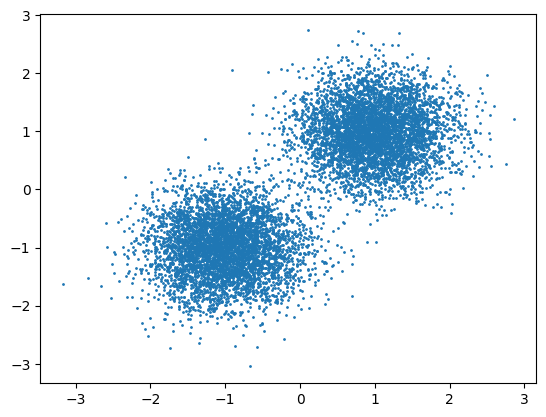

In [ ]:
D = GaussianMixture2DDataset(9999, loc=torch.tensor([[-1, -1], [1,1]]), scale=torch.tensor([[0.5, 0.5], [0.5,0.5]])).samples
plt.scatter(D[:, 0], D[:, 1], 1)
plt.show()

S obzirom da modeliramo 2D skup podatka, zanimaju nas funkcije s domenom $\mathbb{R}^2$ i kodomenom $\mathbb{R}^2$ koje imaju inverz.
Definiramo sljedeći implementacijski ovir:

In [ ]:
class _Bijection(nn.Module):
    def __init__(self):
        super(_Bijection, self).__init__()

    def forward(self, x):
        pass

    def inverse(self, z):
        pass

Funkcija `forward` implementira unaprijedni prolaz kroz sloj i na izlazu vraća transformirani ulaz i logaritam apsolutne vrijednosti determinante Jakobijana funkcije. \
Funkcija `inverse` implementira inverzni probalz kroz sloj i na izlazu vraća transformirani ulaz.

**Zadatak 3.**: Pokušajmo ponuditi bijektivnu alternativu sloju torch.nn.Linear za dvodimenzionalne podatke. Obratite pozornost na to da je transformaciju potrebno održavati invertibilnom regularizacijskim članom.
Nadopunite forward i inverse funkciju.

Uputa: Linearna transformacija se primjenjuje na svaki primjer u minigrupi nezavisno. Zbog malene dimenzionalnosti, invertiranje i računanje determinante Jakobijana možemo izvesti grubom silom, izravnim pozivom odgovarajućih funkcija torcha.

In [ ]:
def sum_except_batch(x, num_dims=1):
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

class BijectiveLinear2D(_Bijection):
    def __init__(self, dim):
        super(_Bijection, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.eye(dim))
        self.bias = nn.Parameter(torch.zeros(1, dim))

    def forward(self, x):
        z = x @ self.weight.T + self.bias
        log_abs_det = torch.logdet(self.weight).expand(x.shape[0])
        return z, log_abs_det

    def inverse(self, z):
        weight_inv = torch.inverse(self.weight)
        x = (z - self.bias) @ weight_inv.T
        return x

    def regularization(self):
        return ((self.weight @ self.weight) - torch.eye(self.dim)).abs().sum()




**Zadatak 4.**: Nadopunjavanje izvedbe osnovnog razreda `NormalizingFlow`.

Proučite predloženu nepotpunu izvedbu razreda `NormalizingFlow`. Obratite pozornost na to da konstruktor razreda prima argument `transforms` koji mora biti tipa [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) kako bismo kroz taj objekt mogli iterirati pri unaprijednom i inverznom prolazu. Iteraciju ćemo provoditi `for` petljom i tako prolaziti kroz slojeve normalizirajućeg toka. Predložite potpunu izvedbu razreda `NormalizingFlow` pod pretpostavkom da svi elementi slijednog modela `transforms` nasljeđuju prethodno definirano sučelje `_Bijection`. Vaše rješenje može dodavati nove lokalne metode razredu `NormalizingFlow`.



In [ ]:
class NormalizingFlow(nn.Module):
    def __init__(self, transforms, input_dim):
        super(NormalizingFlow, self).__init__()
        self.transforms = transforms

        self.register_buffer('loc', torch.zeros(input_dim))
        self.register_buffer('log_scale', torch.zeros(input_dim))
        self.base_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))

    def forward(self, x):
        log_abs_det_total = 0
        for transform in self.transforms:
          x,log_abs_det = transform(x)
          log_abs_det_total += log_abs_det
        return x, log_abs_det_total

    def inverse(self, z):
        if isinstance(z, tuple):
          z = z[0]
        for transform in reversed(self.transforms):
          z = transform.inverse(z)
        return z

    def log_prob(self, x):
        z, log_abs_det = self.forward(x)
        loc = self.loc.to(z.device)
        log_scale = self.log_scale.to(z.device)
        base_dist = torch.distributions.Normal(loc, torch.exp(log_scale))
        log_pz = base_dist.log_prob(z).sum(-1)
        log_px =  log_pz + log_abs_det
        return log_px

    def sample(self, num_samples, T=1):
        z = self.base_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x

U jednostavnom slučaju, transformaciju normalizirajućeg toka možemo definirati kao slijed linearnih transformacija:



In [ ]:
class SimpleNF(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for _ in range(num_steps):
            transforms.append(BijectiveLinear2D(input_dim))

        super(SimpleNF, self).__init__(transforms=transforms, input_dim=input_dim)

    def gather_regularization(self):
        return sum([m.regularization() for m in self.transforms])

Provjerite svoju implementaciju inverza sljedećim kodom:

In [ ]:
flow = SimpleNF(2, num_steps=7)
print((flow.inverse(flow(D)) - D).sum().item())
assert (flow.inverse(flow(D)) - D).sum() < 1e-9

0.0


Tok učimo optmizacijom prethodno objašnjenog gubitka.

In [ ]:
flow = SimpleNF(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-1)

for iter in range(4000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    loss_reg = flow.gather_regularization()
    total_loss = loss + 0.001 * loss_reg
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()} Reg:{loss_reg.item()}")

Iter 1: Loss:3.0862061977386475 Reg:0.0
Iter 21: Loss:2.546647310256958 Reg:3.069650888442993
Iter 41: Loss:2.5802865028381348 Reg:3.089256763458252
Iter 61: Loss:2.549349546432495 Reg:3.196409225463867
Iter 81: Loss:2.546848773956299 Reg:3.2014615535736084
Iter 101: Loss:2.5466535091400146 Reg:3.1982078552246094
Iter 121: Loss:2.546635150909424 Reg:3.1943891048431396
Iter 141: Loss:2.546633243560791 Reg:3.1906139850616455
Iter 161: Loss:2.5466325283050537 Reg:3.186941623687744
Iter 181: Loss:2.546633243560791 Reg:3.1833760738372803
Iter 201: Loss:2.546633005142212 Reg:3.179917097091675
Iter 221: Loss:2.546633005142212 Reg:3.176560401916504
Iter 241: Loss:2.546633005142212 Reg:3.1733040809631348
Iter 261: Loss:2.546633005142212 Reg:3.1701455116271973
Iter 281: Loss:2.546633005142212 Reg:3.167081594467163
Iter 301: Loss:2.546632766723633 Reg:3.16410756111145
Iter 321: Loss:2.546632766723633 Reg:3.161224842071533
Iter 341: Loss:2.546632766723633 Reg:3.1584272384643555
Iter 361: Loss:2.54

Ako ste do sada sve napravili kako treba, predloženi postav trebao bi uspjeti naučiti tok s gubitkom od oko 2.5.

Provjerimo još jednom stabilnost inverza. Kako biste komentrali rezultate?

In [ ]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(2.3023e-05, grad_fn=<SumBackward0>)


Normalizirajućim tokom možemo generirati primjere na sljedeći način:

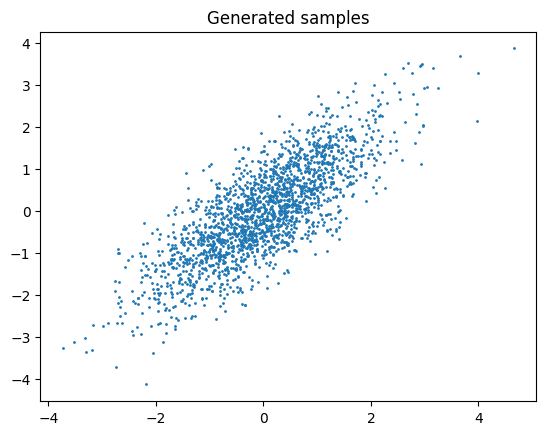

In [ ]:
X_ = flow.sample(2000).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.title("Generated samples")
plt.show()

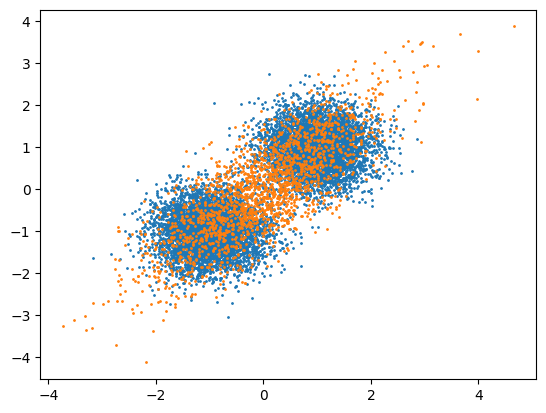

In [ ]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

Tok definiran razredom SimpleNF ne može ostvariti veliki kapacitet jer je kompozicija linearnih transformacija i dalje linearna transformacija. Stoga modelirana distribucija ne uspijeva dovoljno dobro aproksimirati $p_D$. Bolju aproksimaciju dobiti ćemo sofisticiranijom arhitekturom pod nazivom [RealNVP](https://arxiv.org/abs/1605.08803). RealNVP se sastoji od "slojeva" afinog miješanja koji su invertibilni po konstrukciji. Imajte na umu da afino miješanje tipično ostvarujemo s više slojeva dubokog modela jer modul miješanja `net` može sadržavati (i tipično sadrži) veći broj uzastopnih nelinearnih transformacija.

Unaprijedni prolaz kroz afino miješanje s ulazom $\mathbf{x}$ dimenzionalnosti $d$ definiramo kao ($m < d$):
$$
\mathbf{z}_{:m} = \mathbf{x}_{:m}
$$
$$
\mathbf{z}_{m:d} = \exp(\ln\mathbf{s}) \odot \mathbf{x}_{m:d} + \mathbf{t}, \quad \ln s, t = net(\mathbf{x}_{:m})
$$

**Zadatak 5.**: Skicirajte računske grafove unaprijednog i unatražnog prolaza kroz afino miješanje. \
Nadopunite predloženi razred `AffineCouplingLayer` s prikladnom funkcionalnošću.
Afino miješanje transformira samo polovicu ulaznog tezora $\mathbf{x}_{m:d}$, dok druga polovica $\mathbf{x}_{:m}$ ostaje nepromijenjena.
Modul miješanja `net` predviđa parametre miješanja `log_s` i `t` iz polovice ulaznog tenzora $\mathbf{x}_{:m}$.

In [ ]:
class AffineCouplingLayer(_Bijection):
    def __init__(self, net):
        super(AffineCouplingLayer, self).__init__()
        self.net = net

    def forward(self, x):
        x1,x2 = torch.chunk(x,chunks=2, dim=1)
        log_s, t = self.net(x1)
        z1 = x1
        z2 = x2 * torch.exp(log_s) + t
        z = torch.cat([z1,z2], dim=1)
        log_det = torch.sum(log_s, dim=1)
        return z, log_det

    def inverse(self, y):
        y1,y2 = torch.chunk(y, chunks=2, dim=1)
        log_s, t = self.net(y1)
        x1 = y1
        x2 = (y2-t)*torch.exp(-log_s)
        x = torch.cat([x1,x2], dim=1)
        return x

**Zadatak 6.:** Zamislimo situaciju gdje slijedno primjenjujemo više coupling slojeva. Možemo primijetiti da će se miješati samo jedna polovica tenzora. Kako bismo osigurali da se miješaju obje polovice ulaznog tenzora, uvodimo transformaciju `SwitchSides` koju ćemo primijeniti nakon svakog coupling sloja.
Na taj način osiguravamo da miješanje provodimo naizmjenično na dvjema polovicama ulaznog tenzora. \
Tenzor dijelimo po dimenziji značajki. Dovršite implementaciju razreda `SwitchSides` tako da dijeli ulazni tenzor na dva dijela po dimenziji značajki i zamjenjuje im strane. Možete iskoristiti funkcije [chunk](https://pytorch.org/docs/stable/generated/torch.chunk.html) i [cat](https://pytorch.org/docs/stable/generated/torch.cat.html).

In [ ]:
class SwitchSides(_Bijection):

    def forward(self, x):
        x1,x2 = torch.chunk(x, chunks=2, dim=1)
        y = torch.cat([x2, x1], dim=1)
        return y, 0.

    def inverse(self, z):
        z1, z2 = torch.chunk(z, chunks=2, dim=1)
        x = torch.cat((z2, z1), dim=1)
        return x

**Zadatak 7.:**U nastavku je dan razred `SimpleTransform` kojeg ćemo koristiti kao modul afinog miješanja u coupling sloju. Primijetite da će primjerci tog razreda biti atributi `net` razreda `AffineCouplingLayer`.\
Dovršite implementaciju tako da `model` bude potpuno povezani modul sljedeće arhitekture:

`fc(dim, internal_dim) -> relu -> fc(internal_dim, internal_dim) -> relu -> fc(internal_dim, 2*dim)`.

Dimenziju skrivenog sloja potpuno povezanog modula određujemo parametrom `inflate_coef`. \


Inicijalizirajte parametre modula miješanja tako da modul provodi transformaciju koja je jednaka identitetu. \

In [ ]:
class SimpleTransform(nn.Module):
    def __init__(self, dim, inflate_coef=1):
        super(SimpleTransform, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Linear(dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, 2*dim)
        )
        self.initialize_to_identity()

    def initialize_to_identity(self):
      for layer in self.model:
        if isinstance(layer, nn.Linear):
          nn.init.zeros_(layer.weight)
          nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t

In [ ]:
class SimpleRealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        transforms = nn.Sequential()
        for i in range(num_steps):
            transforms.append(AffineCouplingLayer(SimpleTransform(input_dim//2)))
            if i != num_steps - 1:
                transforms.append(SwitchSides())
        super(SimpleRealNVP, self).__init__(transforms, input_dim)


Tok možemo naučiti na način kako slijedi:

In [ ]:
flow = SimpleRealNVP(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-2, nesterov=True, momentum=0.9)

for iter in range(2000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    total_loss = loss
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()}")

Iter 1: Loss:3.0862061977386475
Iter 21: Loss:3.0598952770233154
Iter 41: Loss:3.0596628189086914
Iter 61: Loss:3.0596466064453125
Iter 81: Loss:3.0596468448638916
Iter 101: Loss:3.0596468448638916
Iter 121: Loss:3.0596466064453125
Iter 141: Loss:3.0596466064453125
Iter 161: Loss:3.0596466064453125
Iter 181: Loss:3.0596466064453125
Iter 201: Loss:3.0596466064453125
Iter 221: Loss:3.0596466064453125
Iter 241: Loss:3.0596466064453125
Iter 261: Loss:3.0596466064453125
Iter 281: Loss:3.0596466064453125
Iter 301: Loss:3.0596466064453125
Iter 321: Loss:3.0596466064453125
Iter 341: Loss:3.0596466064453125
Iter 361: Loss:3.0596466064453125
Iter 381: Loss:3.0596466064453125
Iter 401: Loss:3.0596466064453125
Iter 421: Loss:3.0596466064453125
Iter 441: Loss:3.0596466064453125
Iter 461: Loss:3.0596466064453125
Iter 481: Loss:3.0596466064453125
Iter 501: Loss:3.0596468448638916
Iter 521: Loss:3.0596468448638916
Iter 541: Loss:3.0596468448638916
Iter 561: Loss:3.0596466064453125
Iter 581: Loss:3.059

In [ ]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(3.4222e-05, grad_fn=<SumBackward0>)


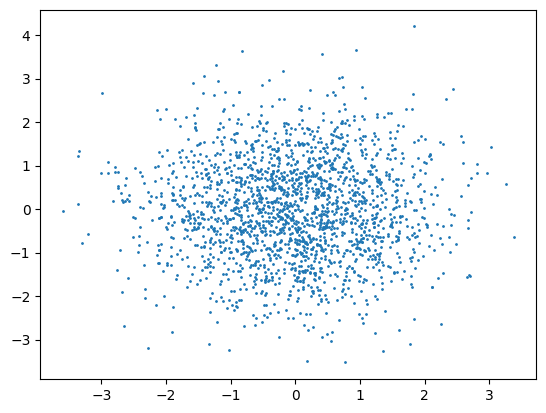

In [ ]:
X_ = flow.sample(2000, 1).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

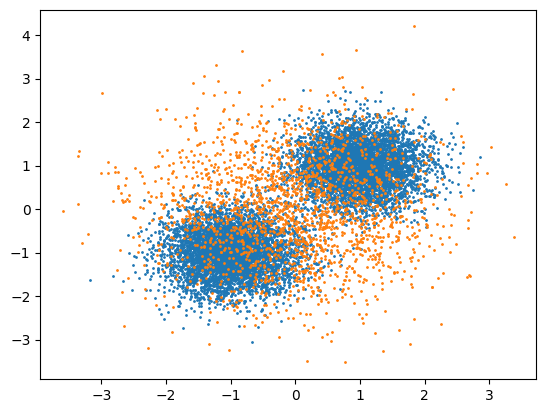

In [ ]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)

Kao što vidite, kapacitetniji tok uspijeva dobro aproksimirati dani skup podataka.

## Modeliranje slika normalizirajućim tokom

Naš sljedeći zadatak je modelirati distribuciju slika s normalizirajućim tokom. Slike možemo prestaviti diskretnim tenzorom $\mathbf{x} \in [0, 255]^{C \times H \times W}$. Prisjetimo se da smo normalizirajući tok definirali za kontinuirane slučajne varijable. Stoga, potrebno je transfrormirati skup podataka u kontinuiranu domenu pomoću zašumljivanja:

$$
\mathbf{y} = \mathbf{x} + \mathbf{u}, \quad \mathbf{u} \sim \mathrm{U}[0, 1)
$$
U prestavlja uniformnu razdiobu. Sada, naš model uči modelirati zašumljenu sliku. Više o dekvantizaciji zašumljivanjem možete pronaći [ovdje](https://arxiv.org/pdf/1511.01844.pdf).

MNIST je skup jednostavnih slika pa ćemo se sljedećim pojednostavljenjem. Sliku ćemo ispeglati u vektor i normalizirajućim tokom učiti takvu reprezentaciju slike.

U nastavku je dan kod za pripremanje skupa slika.

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as tf
from torch.utils.data import DataLoader, Subset

In [ ]:
train_ds = MNIST('.', train=True, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))
test_ds = MNIST('.', train=False, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))

selected_number = 0

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, train_ds[i][1]) for i in range(len(train_ds))]))]
train_ds = Subset(train_ds, indices)

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, test_ds[i][1]) for i in range(len(test_ds))]))]
test_ds = Subset(test_ds, indices)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.92MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
def plot_mnist(samples, num_row, num_col):
    assert len(samples) ==  num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(samples)):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(samples[i], cmap='gray')
    plt.tight_layout()
    plt.show()

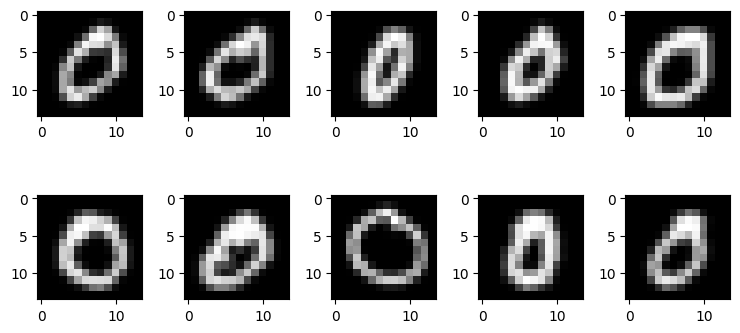

In [ ]:
samples = [train_ds[i][0][0] for i in range(10)]
plot_mnist(samples, 2, 5)

**Zadatak 8.:** Predložite arhitekturu toka koji će moći naučiti distribuciju vektoriziranih slika. Predlažemo koristiti rezidualni blok sljedeće arhitekture.

`fc(dim, dim) -> BN -> relu -> fc(dim, dim) -> relu`

Potrebno je dodati rezidualnu vezu od ulaza u rezidualni blok do latentne reprezentacije prije posljednje zglobnice.
Dovršite implementaciju i validirajte utjecaj batchnorma na proces učenja i konačne rezultate.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_bn=False):
        super(ResidualBlock, self).__init__()
        layers = []

        layers.append(nn.Linear(dim, dim))
        if use_bn:
            layers.append(nn.BatchNorm1d(dim))
        layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Linear(dim, dim))
        layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        identity = x
        out = self.layers(x)
        out = out + identity
        return nn.functional.relu(out)

**Zadatak 9.:** Po uzoru na razred `SimpleTransform` dovršite implementaciju razreda `SimpleResidualTransform` čiji se modul miješanja sastoji od rezidualnih blokova. Predlažemo sljedeću arhitekturu:

`fc(dim, internal_dim) -> relu -> res_block(internal_dim, internal_dim) -> fc(internal_dim, 2*dim)`

Eksperimentirajte s brojem rezidualnih blokova. Kako broj rezidualnih blokova utječe na rezultate?

In [ ]:
class SimpleResidualTransform(nn.Module):
    def __init__(self, dim, inflate_coef=1, num_residual_blocks=2):
        super(SimpleResidualTransform, self).__init__()
        internal_dim = dim * inflate_coef

        self.fc1 = nn.Linear(dim, internal_dim)
        self.relu = nn.ReLU(inplace=True)

        self.residual_blocks = nn.ModuleList(
            [ResidualBlock(internal_dim, use_bn=False) for _ in range(num_residual_blocks)]
        )

        self.fc2 = nn.Linear(internal_dim, 2 * dim)

    def forward(self, x):
        for layer in [self.fc1, self.fc2]:
          layer.weight.data.clamp_(-1, 1)
          layer.bias.data.clamp_(-1, 1)

        out = self.fc1(x)
        out = self.relu(out)

        for block in self.residual_blocks:
            out = block(out)

        out = self.fc2(out)
        log_s, t = torch.chunk(out, dim=1, chunks=2)

        log_s = torch.clamp(log_s, -5, 5)
        t = torch.clamp(t, -5, 5)

        return log_s, t
        return log_s, t

**Zadatak 10.:** Dovršte implementaciju razreda `RealNVP` po uzoru na `SimpleRealNVP`. `RealNVP` treba koristiti `SimpleResidualTransform` umjesto `SimpleTransform` kao modul miješanja.

In [ ]:
class RealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2, inflate_coef=1, num_residual_blocks=2):
        transforms = []
        for i in range(num_steps):
            mask = self.create_mask(input_dim, i % 2 == 0)

            net = SimpleResidualTransform(input_dim // 2, inflate_coef, num_residual_blocks)
            transforms.append(AffineCouplingLayer(net))
            if i != num_steps - 1:
                transforms.append(SwitchSides())

        transforms = nn.Sequential(*transforms)

        super(RealNVP, self).__init__(transforms, input_dim)

    @staticmethod
    def create_mask(dim, even):
        mask = torch.zeros(dim)
        mask[::2] = 1 if even else 0
        mask[1::2] = 0 if even else 1
        return mask

U nastavku je kod za učenje toka.

Obratite pozornost na to da izglednost slike prikazujemo u bitovima po dimenziji (BPD). Podsjetite se što ta mjera predstavlja i kako ju računamo.

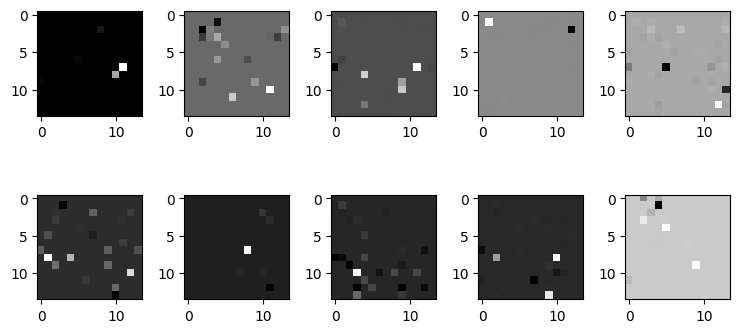

Epoch 1: Train Loss:1304.0694502160904 Val BPD: 9.438960075378418


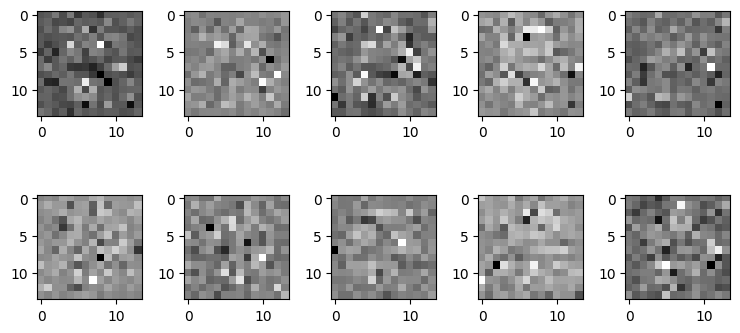

Epoch 11: Train Loss:1062.380952875665 Val BPD: 10.562551498413086


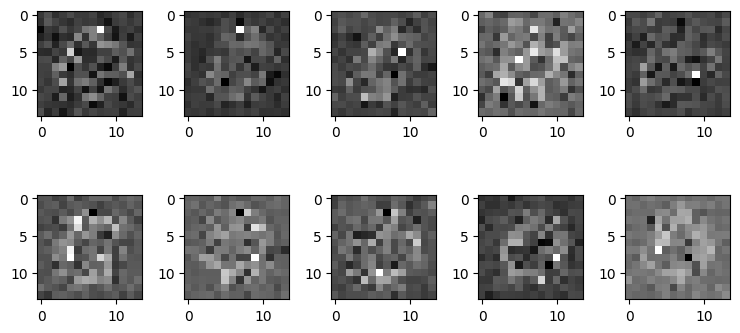

Epoch 21: Train Loss:921.2750257126828 Val BPD: 6.7584075927734375


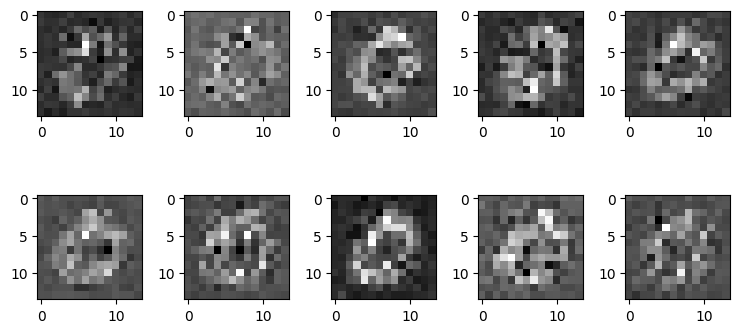

Epoch 31: Train Loss:844.4809453436669 Val BPD: 6.204822540283203


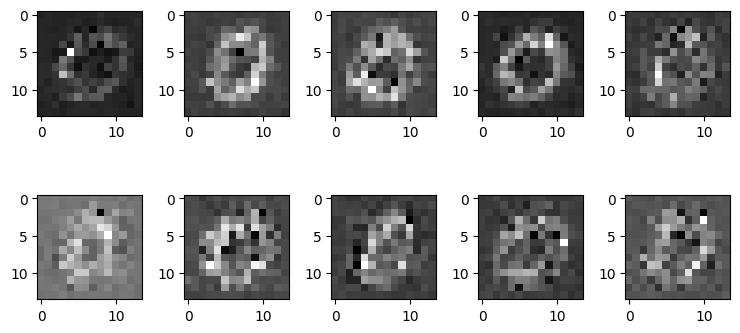

Epoch 41: Train Loss:786.641661299036 Val BPD: 5.792123794555664


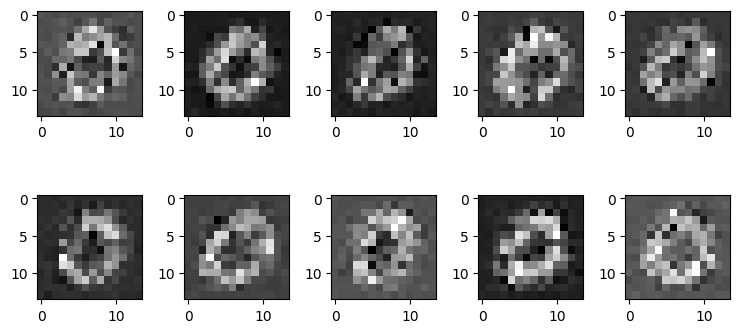

Epoch 51: Train Loss:734.0387638173205 Val BPD: 5.430632591247559


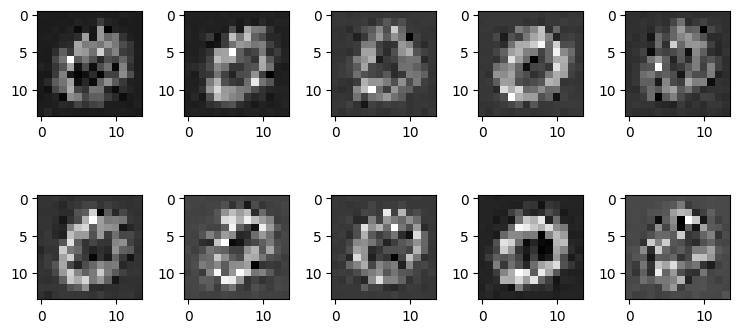

Epoch 61: Train Loss:690.1080685879322 Val BPD: 5.230481147766113


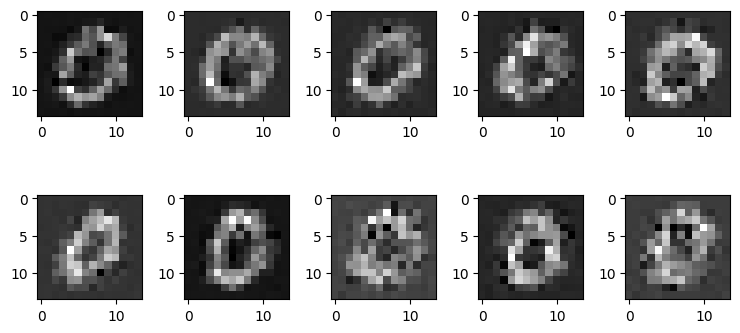

Epoch 71: Train Loss:659.4056006898271 Val BPD: 5.37378454208374


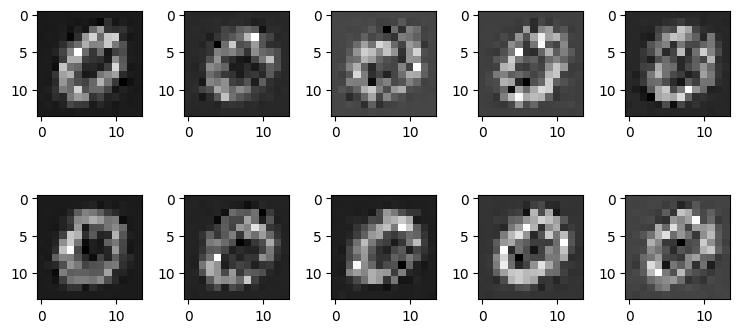

Epoch 81: Train Loss:637.3097248483211 Val BPD: 9.309771537780762


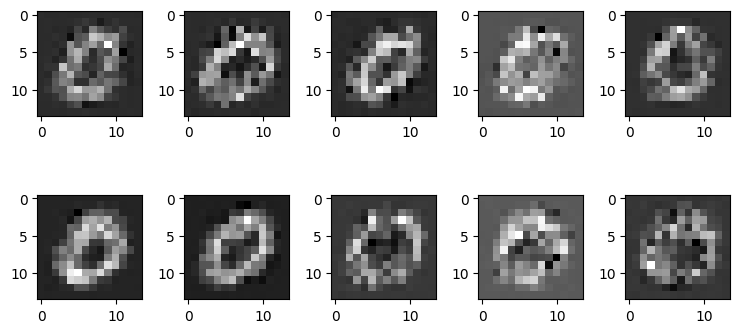

Epoch 91: Train Loss:621.5201766643119 Val BPD: 111.27252960205078


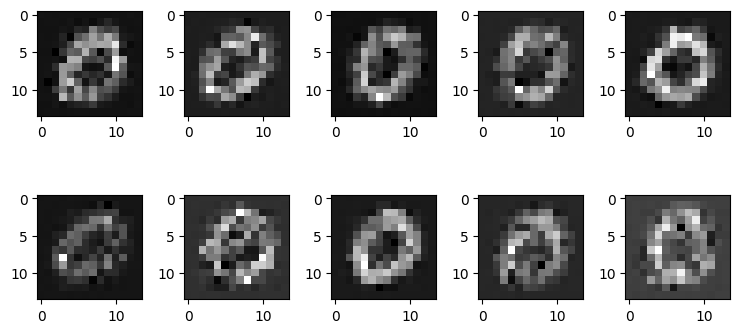

Epoch 101: Train Loss:610.1808432721077 Val BPD: 96.2578353881836


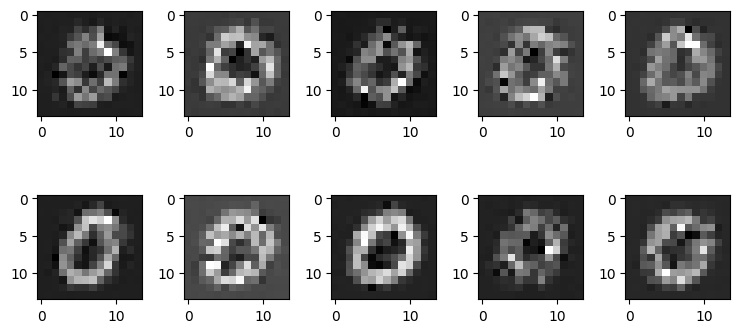

Epoch 111: Train Loss:600.2903520300033 Val BPD: 10.889846801757812


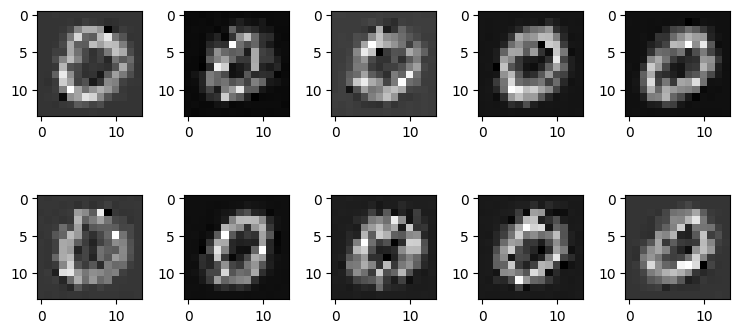

Epoch 121: Train Loss:591.8585607650432 Val BPD: 8.421125411987305


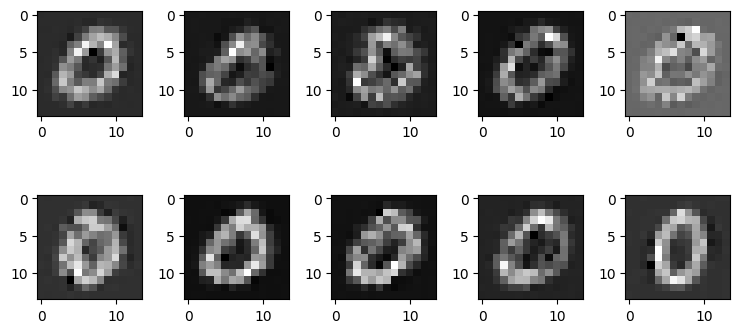

Epoch 131: Train Loss:584.5827610746343 Val BPD: 4.3747429847717285


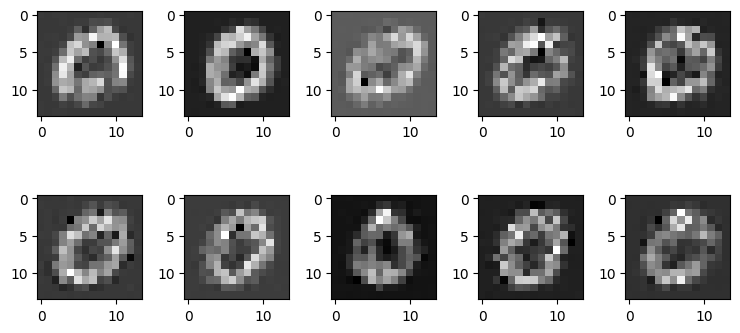

Epoch 141: Train Loss:577.7028509911071 Val BPD: 4.312294006347656


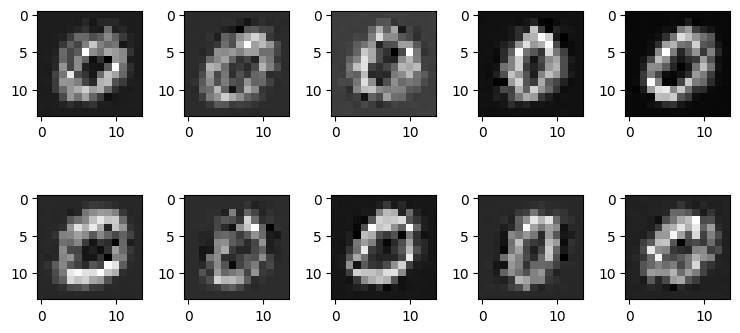

Epoch 151: Train Loss:571.8016604159741 Val BPD: 4.26425838470459


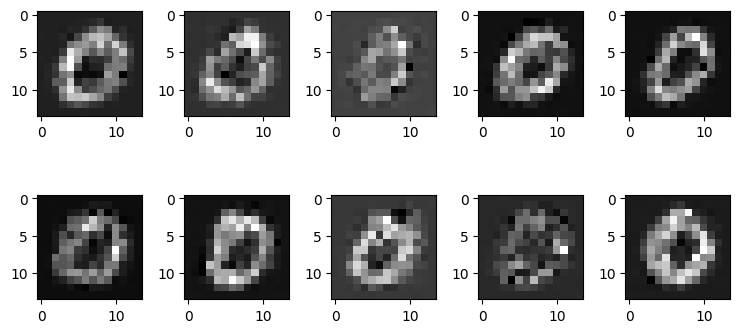

Epoch 161: Train Loss:566.0475269074136 Val BPD: 4.215114593505859


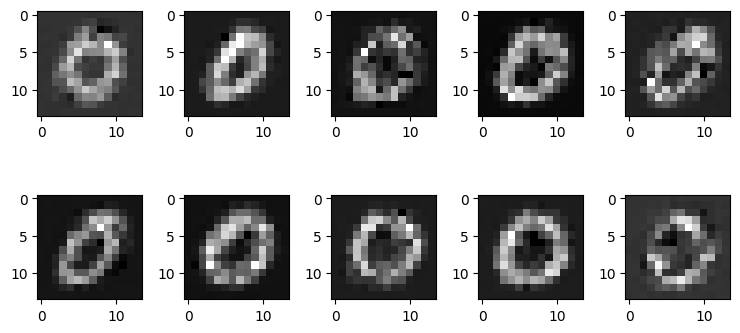

Epoch 171: Train Loss:560.6658662836602 Val BPD: 4.190864562988281


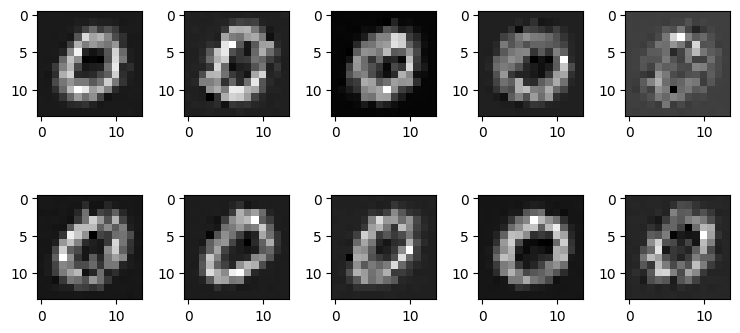

Epoch 181: Train Loss:555.8413968999336 Val BPD: 4.154841899871826


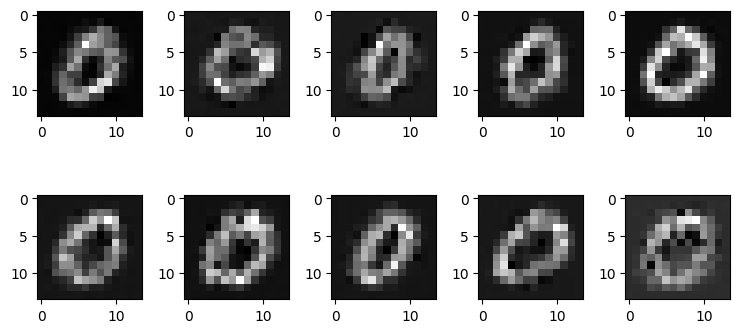

Epoch 191: Train Loss:551.6898427111038 Val BPD: 4.121910095214844


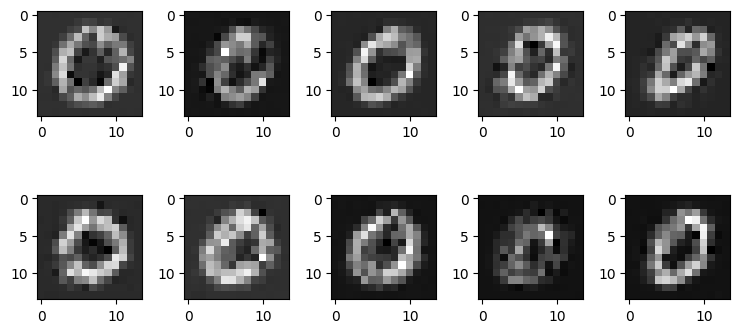

Epoch 201: Train Loss:547.4060318317819 Val BPD: 4.092545986175537


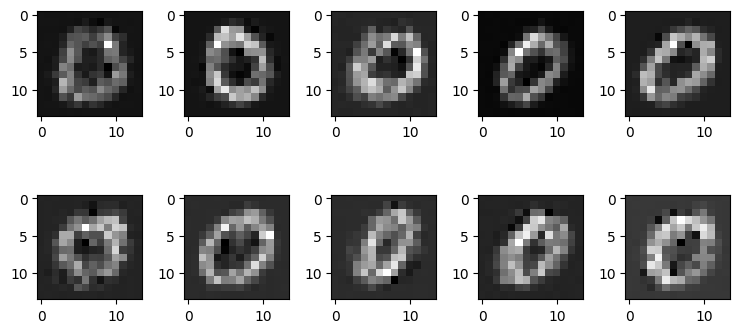

Epoch 211: Train Loss:543.7927362969581 Val BPD: 4.0762457847595215


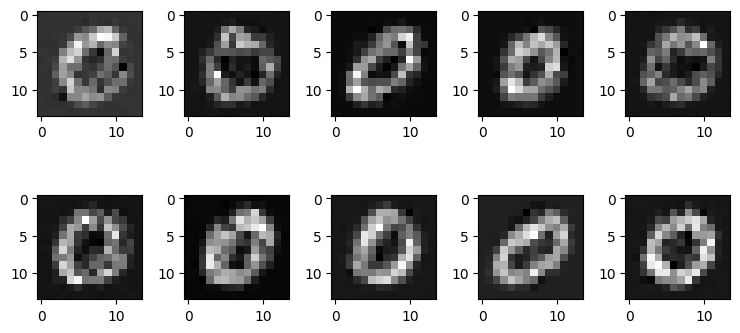

Epoch 221: Train Loss:540.039735185339 Val BPD: 4.062061309814453


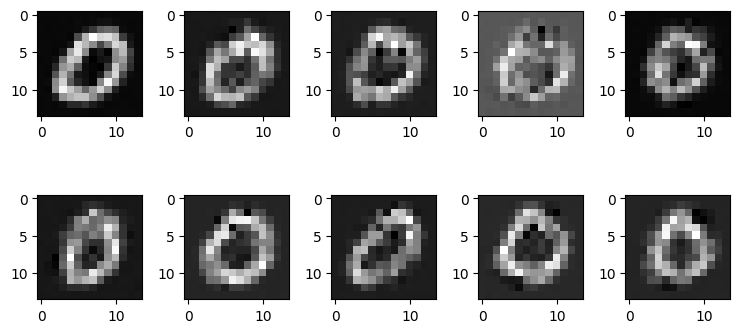

Epoch 231: Train Loss:536.5999600024934 Val BPD: 4.054887771606445


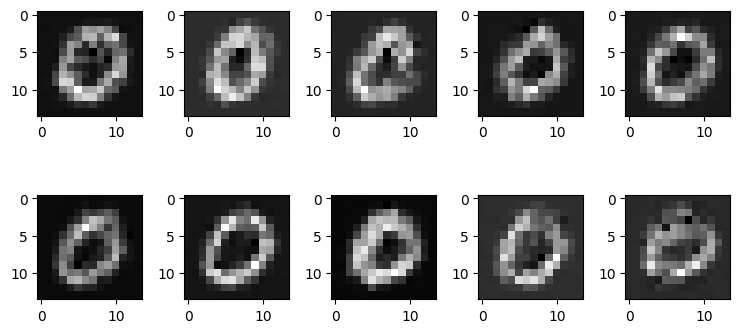

Epoch 241: Train Loss:533.4826374459774 Val BPD: 4.05321741104126


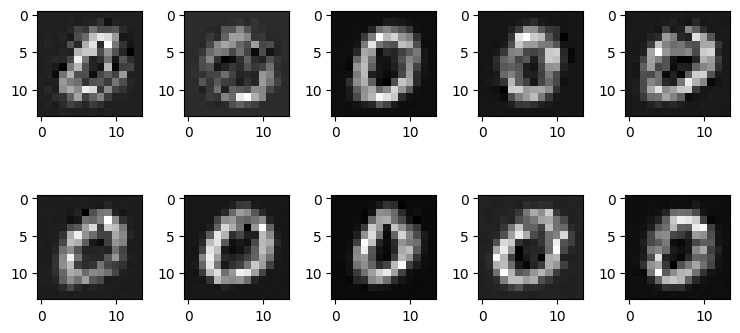

Epoch 251: Train Loss:530.3069639814661 Val BPD: 5.634284973144531


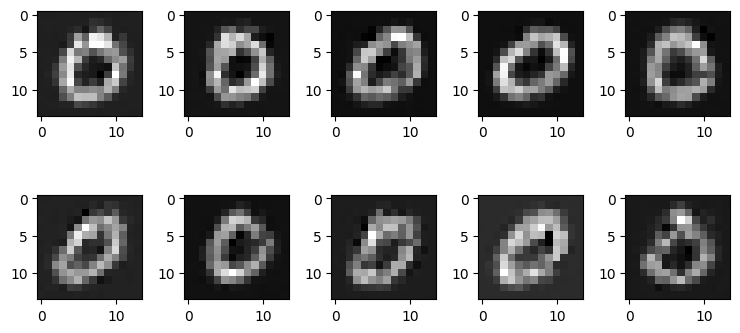

Epoch 261: Train Loss:527.5552588929521 Val BPD: 13.737052917480469


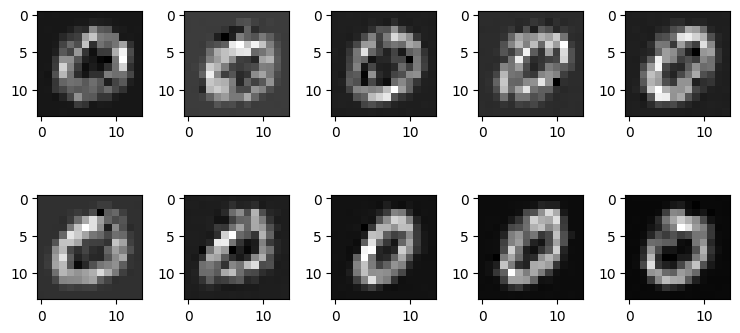

Epoch 271: Train Loss:524.9811881856715 Val BPD: 153.55410766601562


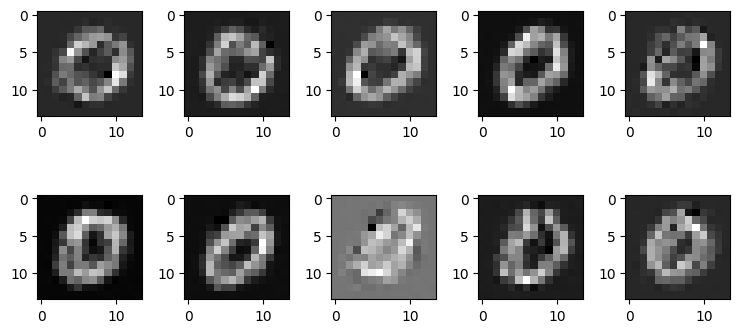

Epoch 281: Train Loss:521.8682225004155 Val BPD: 52.60822296142578


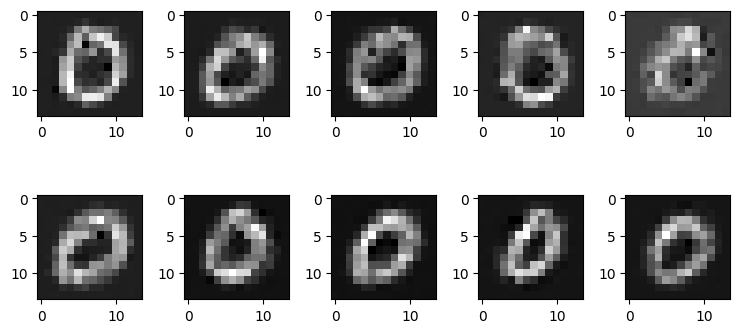

Epoch 291: Train Loss:519.4330788470329 Val BPD: 245.55751037597656


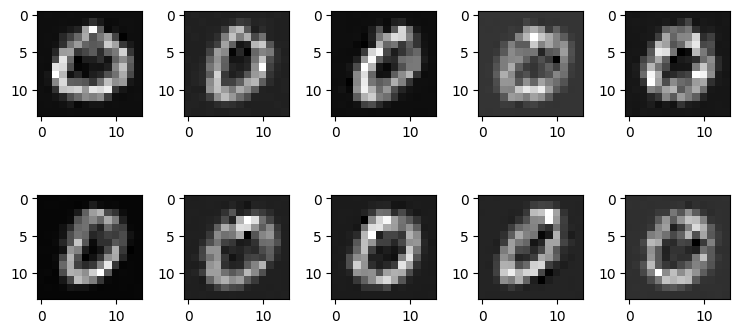

Epoch 301: Train Loss:517.1760935681931 Val BPD: 2308.724365234375


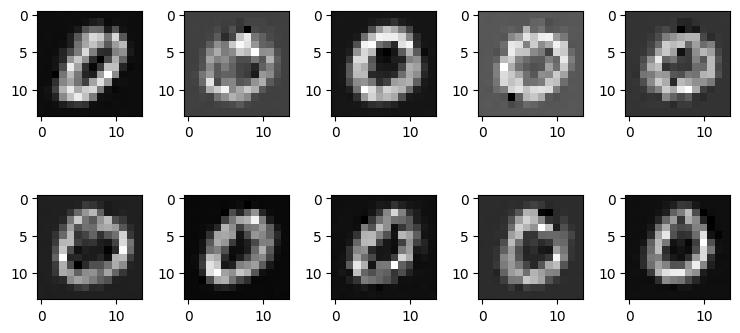

Epoch 311: Train Loss:515.4081576732879 Val BPD: 785.0994262695312


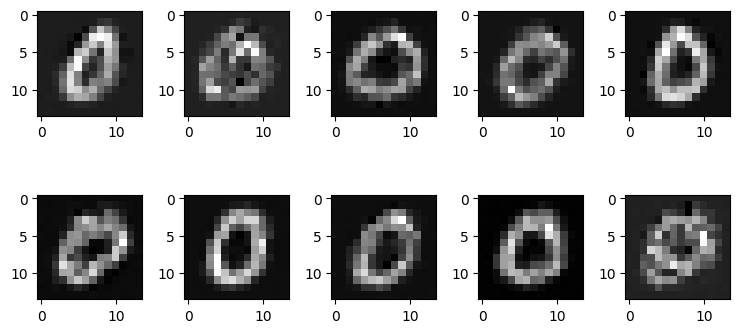

Epoch 321: Train Loss:512.9708063653175 Val BPD: 19122.4921875


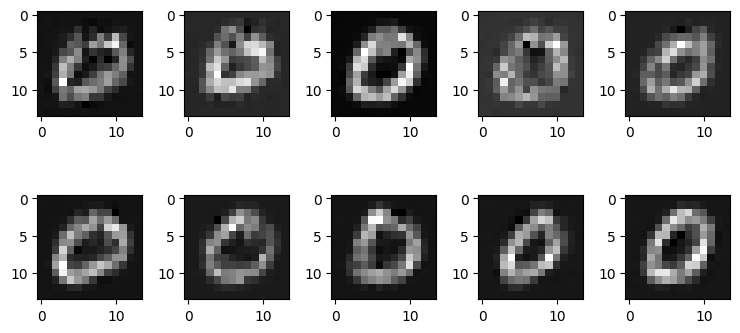

Epoch 331: Train Loss:510.8092878625748 Val BPD: 30583.451171875


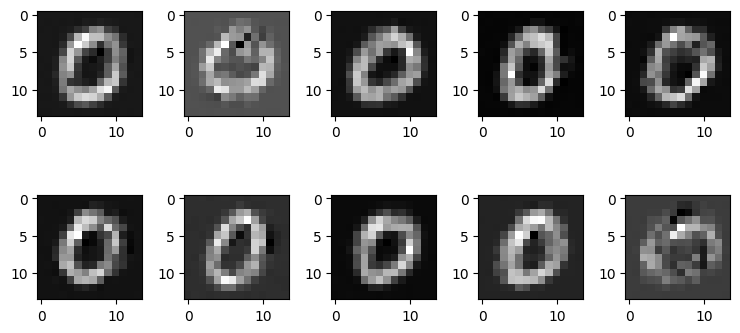

Epoch 341: Train Loss:508.8850065190741 Val BPD: 192662.765625


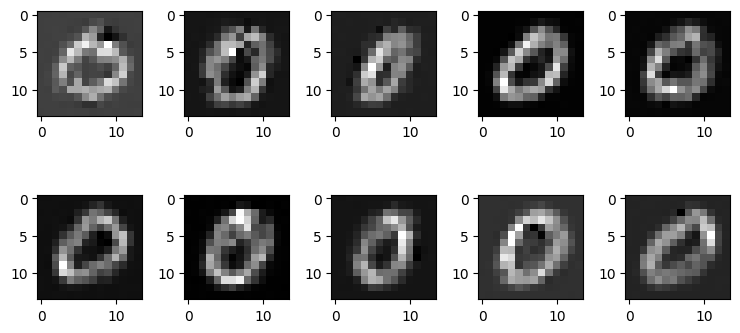

Epoch 351: Train Loss:507.4200101811835 Val BPD: 67824.1953125


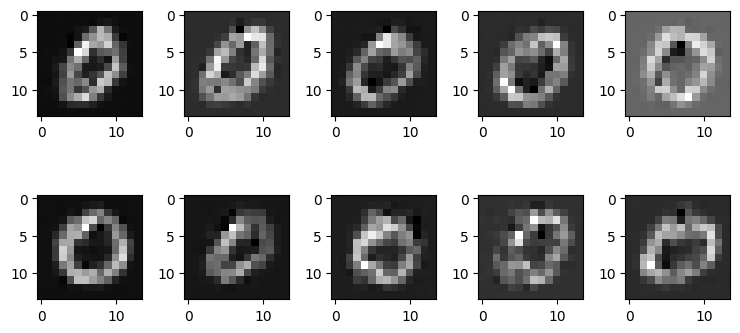

Epoch 361: Train Loss:505.131471674493 Val BPD: 187322.5


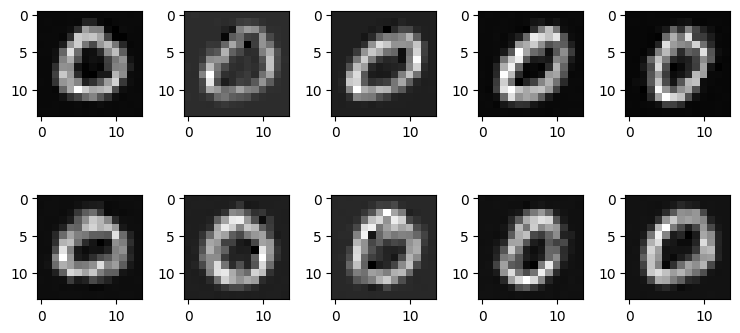

Epoch 371: Train Loss:504.05097149788065 Val BPD: 270056.71875


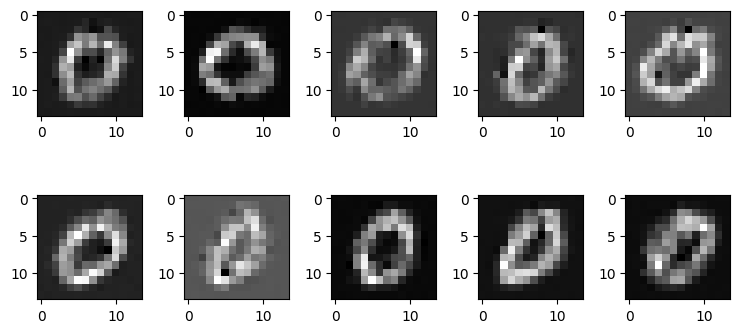

Epoch 381: Train Loss:501.9767611889129 Val BPD: 1130373.875


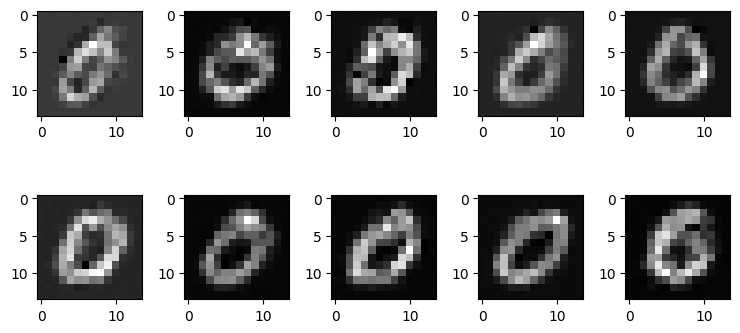

Epoch 391: Train Loss:500.204657372008 Val BPD: 1002968.5625


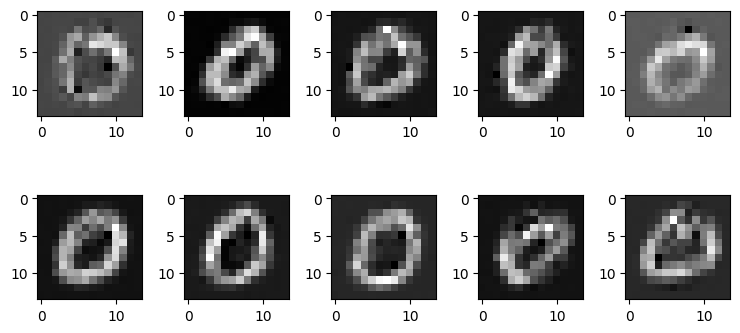

Epoch 401: Train Loss:499.0920819221659 Val BPD: 16806040.0


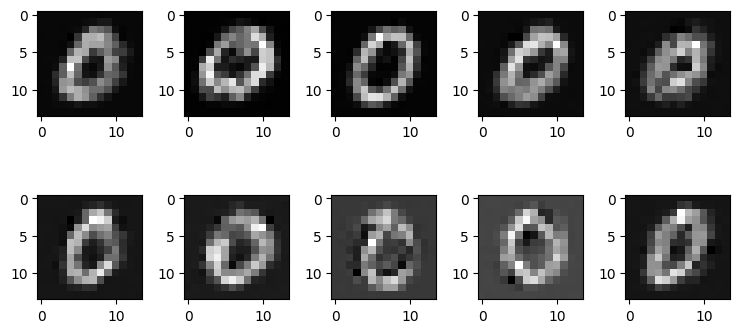

Epoch 411: Train Loss:497.3414955950798 Val BPD: 444556416.0


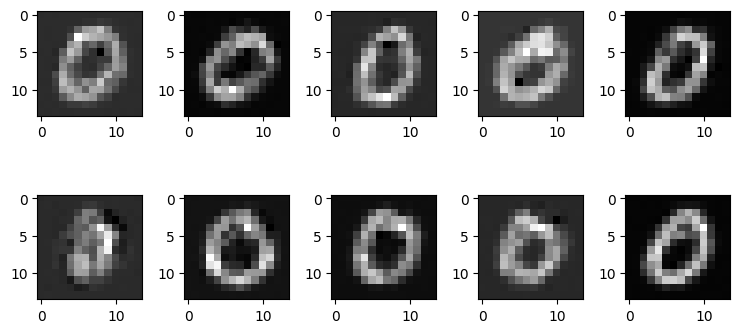

Epoch 421: Train Loss:495.6036039311835 Val BPD: 67840856.0


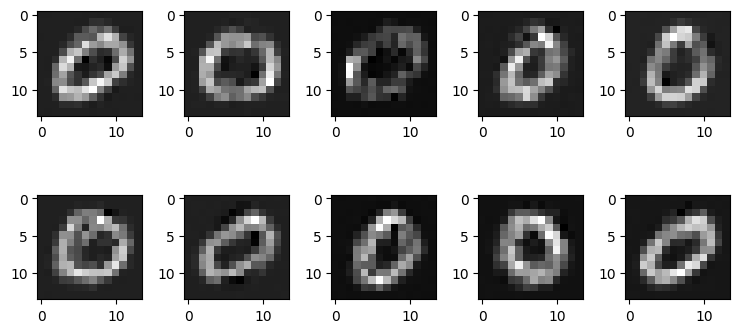

Epoch 431: Train Loss:494.5668555726396 Val BPD: 8629001.0


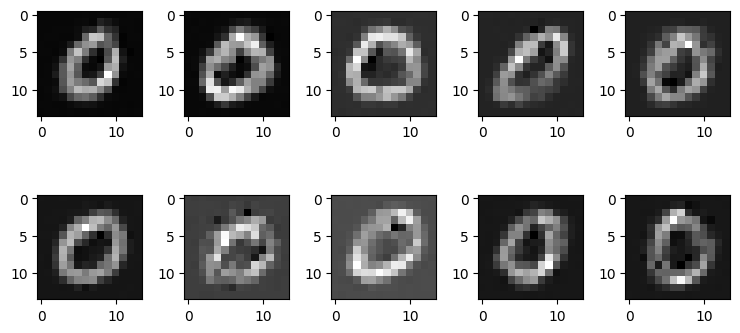

Epoch 441: Train Loss:493.29960405065657 Val BPD: 79576832.0


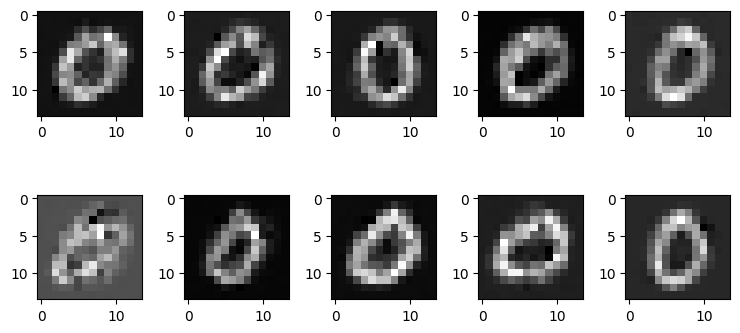

Epoch 451: Train Loss:491.8924119015957 Val BPD: 34727720.0


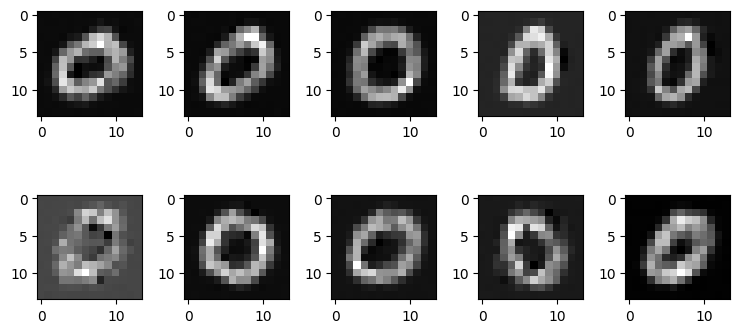

Epoch 461: Train Loss:490.81553877160906 Val BPD: 69225096.0


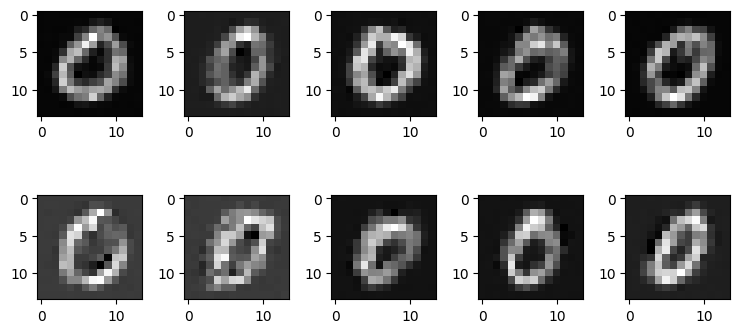

Epoch 471: Train Loss:489.44299900785404 Val BPD: 1433622016.0


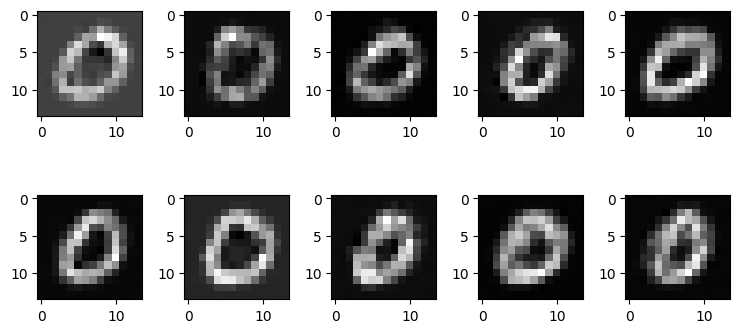

Epoch 481: Train Loss:488.12292934985874 Val BPD: 649599168.0


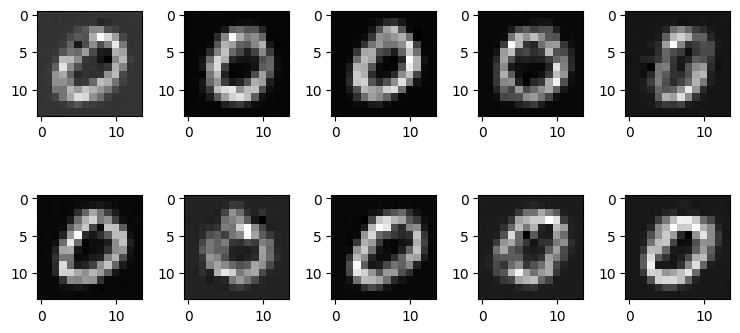

Epoch 491: Train Loss:486.73787543114196 Val BPD: 6460167168.0


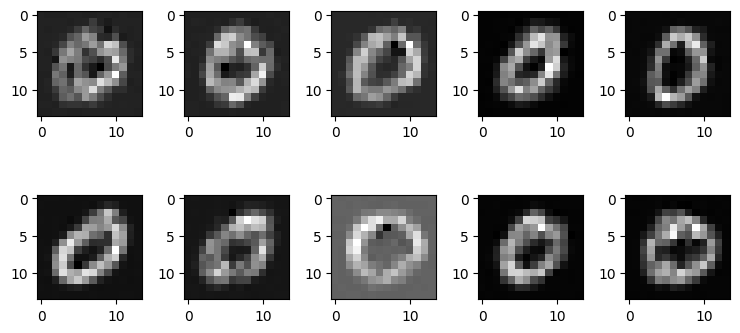

Epoch 501: Train Loss:485.87883287795046 Val BPD: 11369058304.0


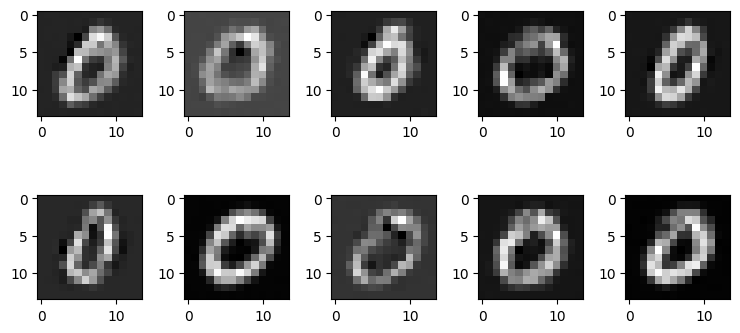

Epoch 511: Train Loss:484.77762944647606 Val BPD: 2479209216.0


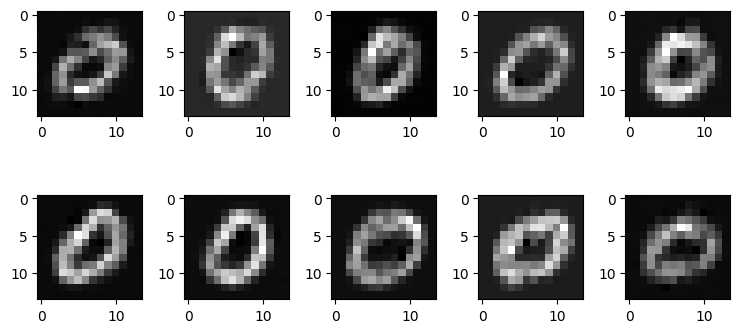

Epoch 521: Train Loss:483.47457690949136 Val BPD: 21583325184.0


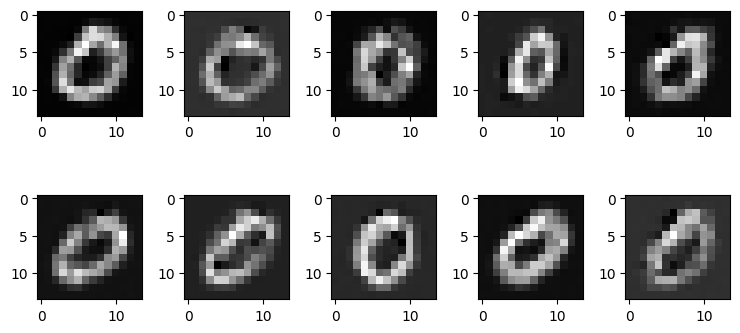

Epoch 531: Train Loss:482.53734182804186 Val BPD: 2830499840.0


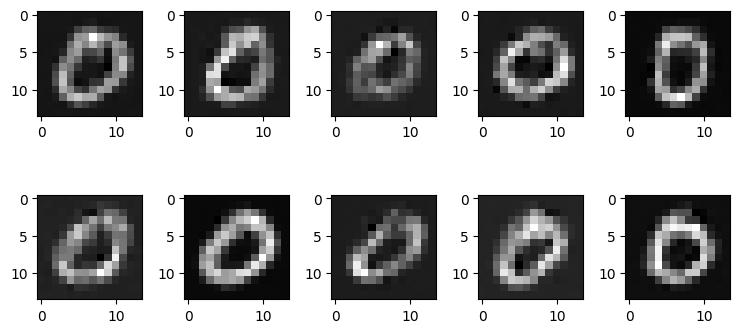

Epoch 541: Train Loss:481.518765063996 Val BPD: 26047641600.0


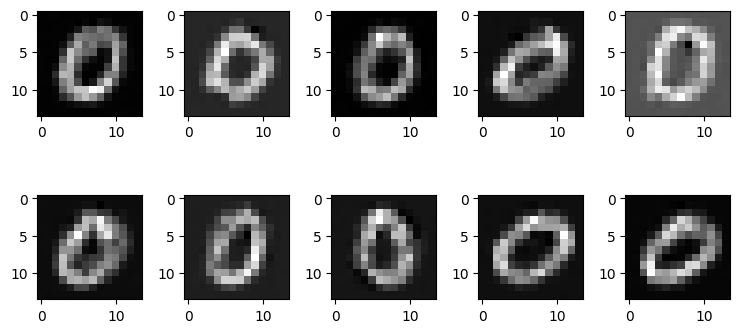

Epoch 551: Train Loss:480.3517183344415 Val BPD: 26409269248.0


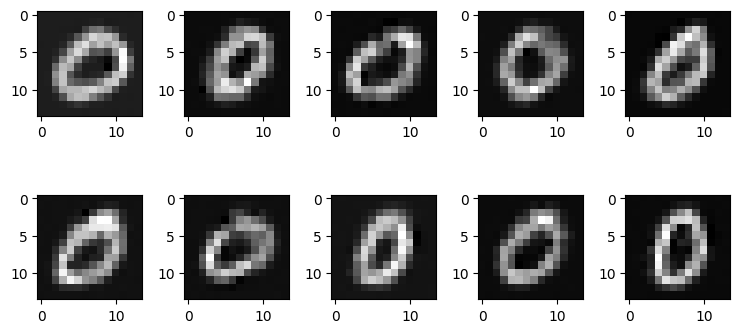

Epoch 561: Train Loss:479.5862465716423 Val BPD: 36192849920.0


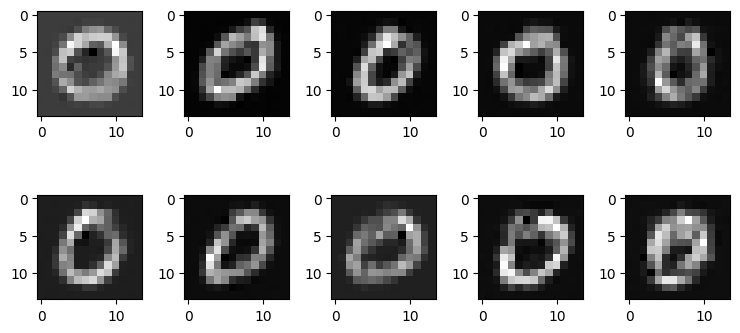

Epoch 571: Train Loss:478.34642775515294 Val BPD: 15646885888.0


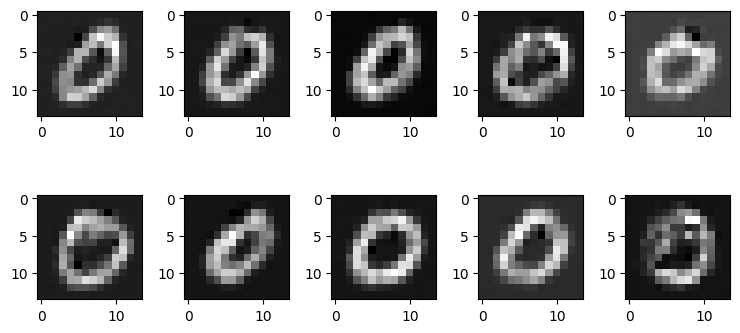

Epoch 581: Train Loss:477.7774145248088 Val BPD: 17988200448.0


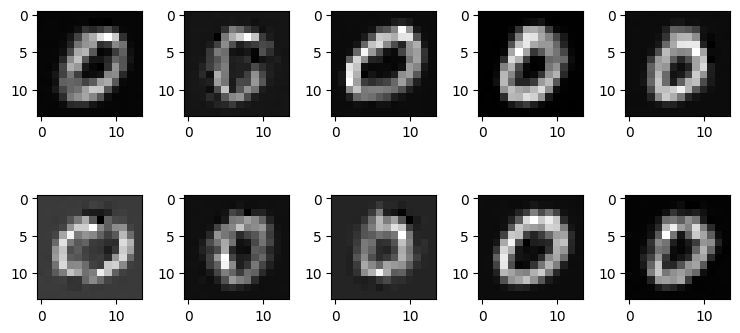

Epoch 591: Train Loss:476.77026107463433 Val BPD: 72592146432.0


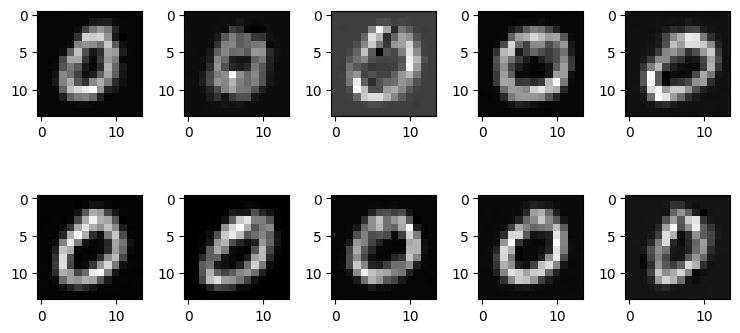

Epoch 601: Train Loss:475.8204436606549 Val BPD: 34160166912.0


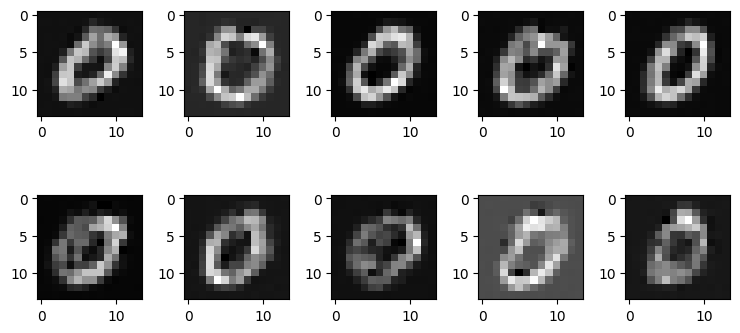

Epoch 611: Train Loss:474.71598199073304 Val BPD: 54684405760.0


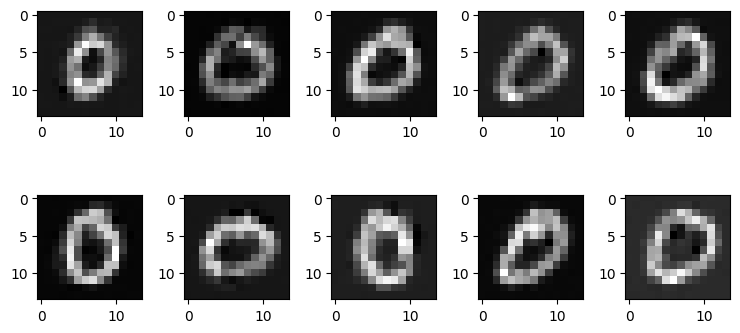

Epoch 621: Train Loss:474.3161335397274 Val BPD: 18745178112.0


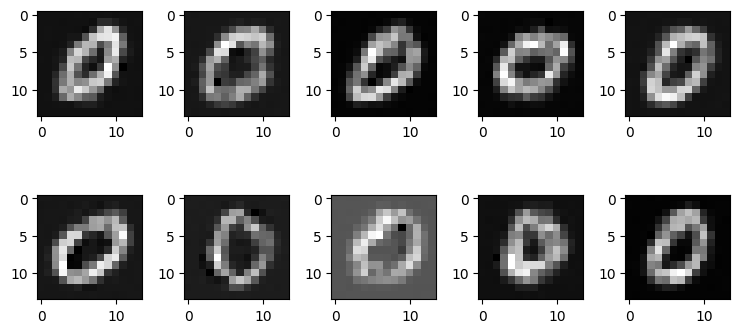

Epoch 631: Train Loss:473.2773106351812 Val BPD: 19267340288.0


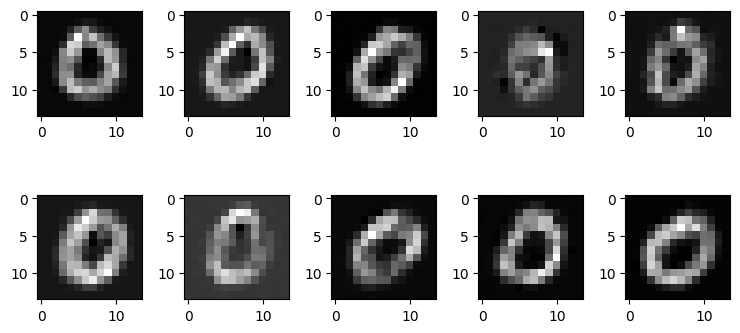

Epoch 641: Train Loss:472.2205622246925 Val BPD: 33041000448.0


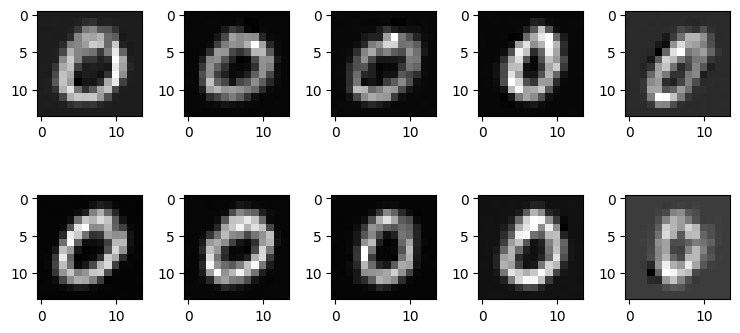

Epoch 651: Train Loss:471.80814312874 Val BPD: 53777457152.0


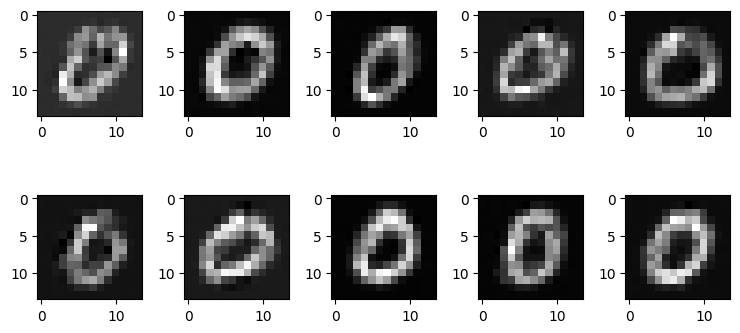

Epoch 661: Train Loss:470.76792615525267 Val BPD: 107992588288.0


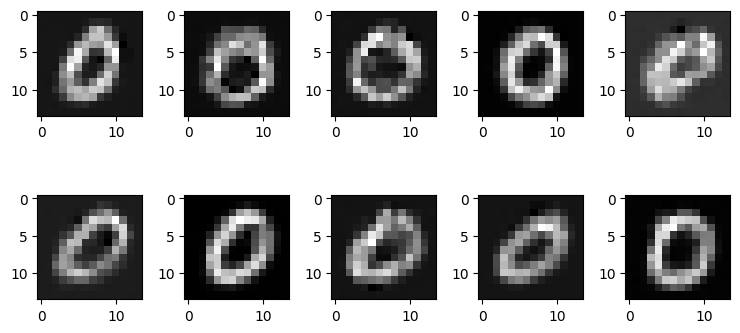

Epoch 671: Train Loss:469.77489130547707 Val BPD: 27329595392.0


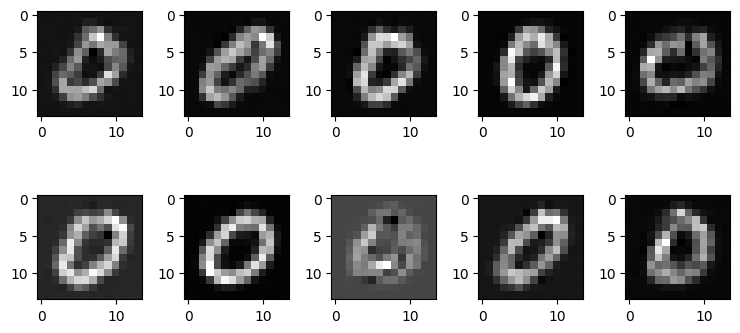

Epoch 681: Train Loss:469.2433822307181 Val BPD: 109412319232.0


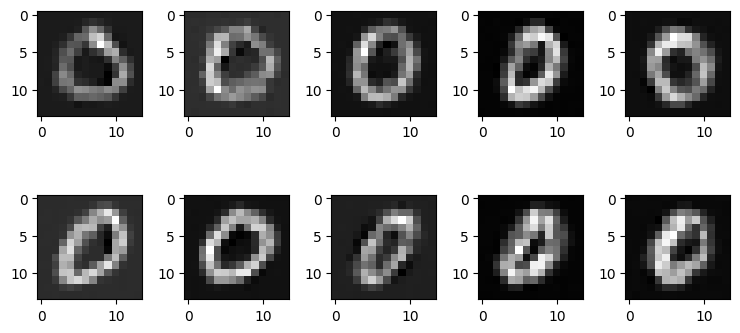

Epoch 691: Train Loss:468.8378393294963 Val BPD: 28423489536.0


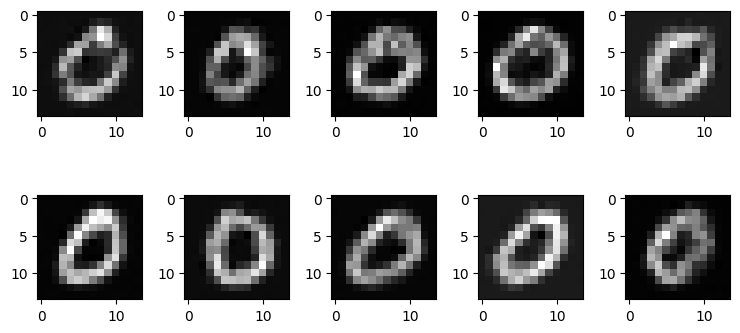

Epoch 701: Train Loss:467.569211919257 Val BPD: 124859400192.0


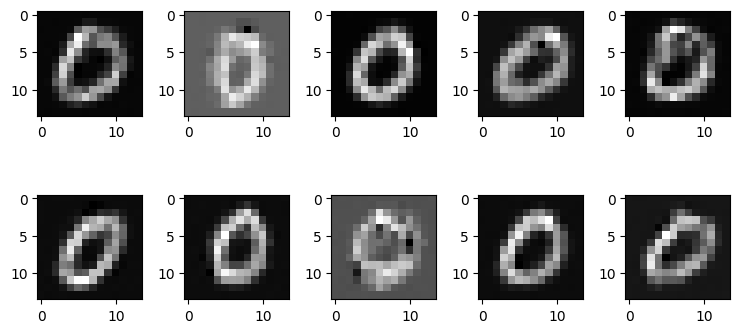

Epoch 711: Train Loss:467.15398975128824 Val BPD: 50510749696.0


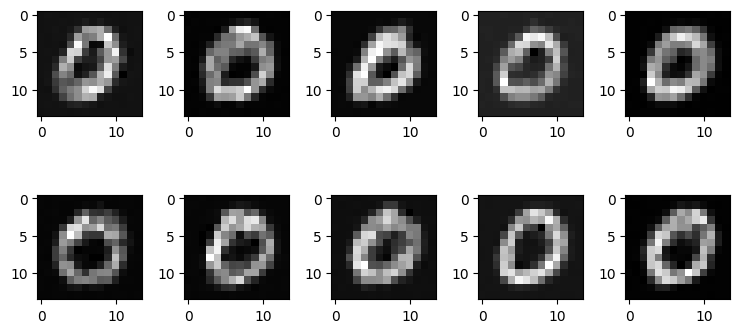

Epoch 721: Train Loss:466.6089419101147 Val BPD: 79129567232.0


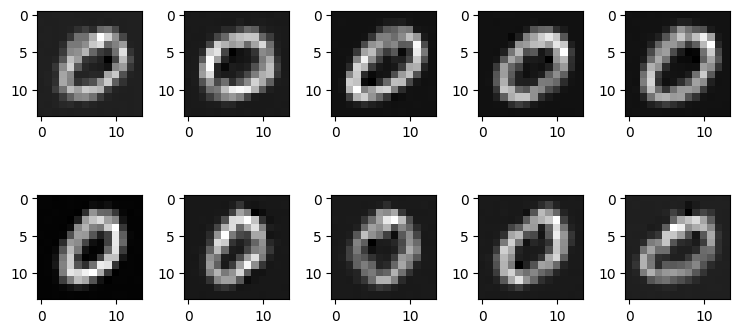

Epoch 731: Train Loss:465.63910106902426 Val BPD: 18688489472.0


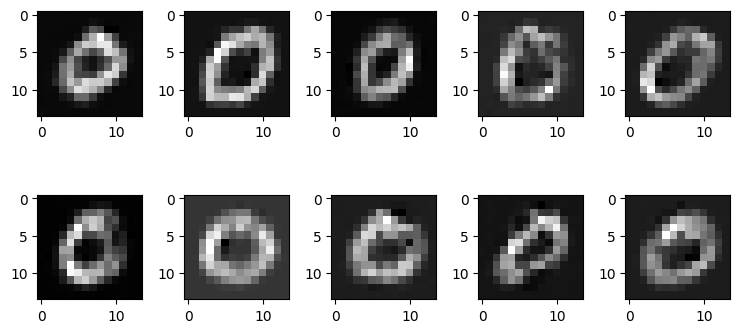

Epoch 741: Train Loss:465.1511178523936 Val BPD: 119024099328.0


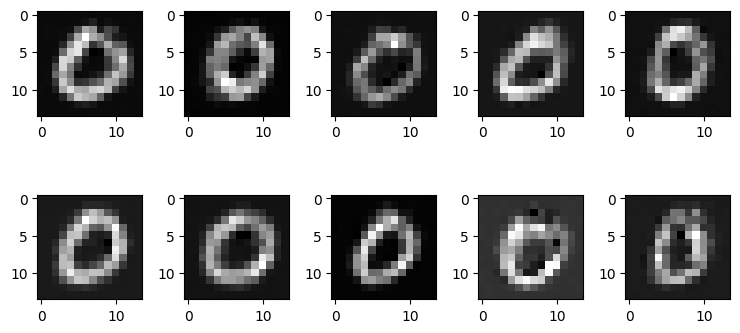

Epoch 751: Train Loss:464.2563866148604 Val BPD: 55216775168.0


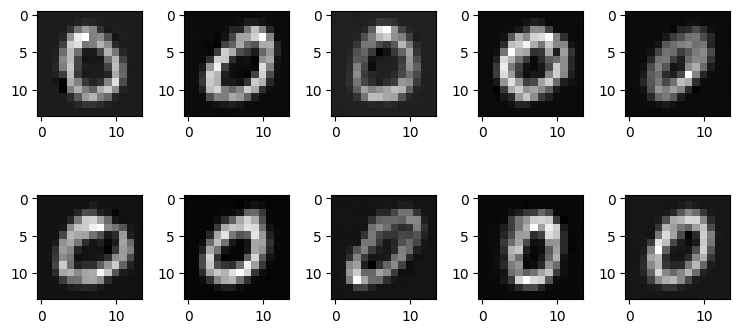

Epoch 761: Train Loss:463.62825629051696 Val BPD: 20055287808.0


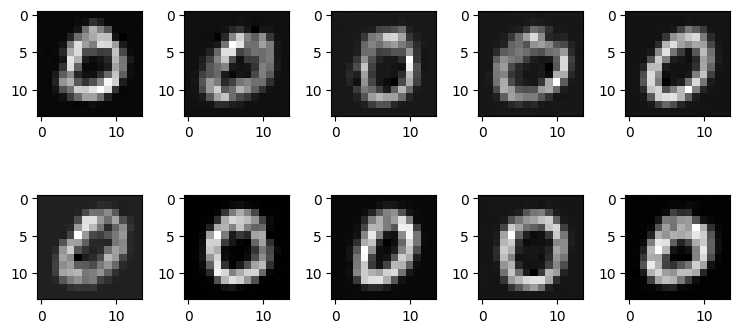

Epoch 771: Train Loss:463.0446121540475 Val BPD: 84720795648.0


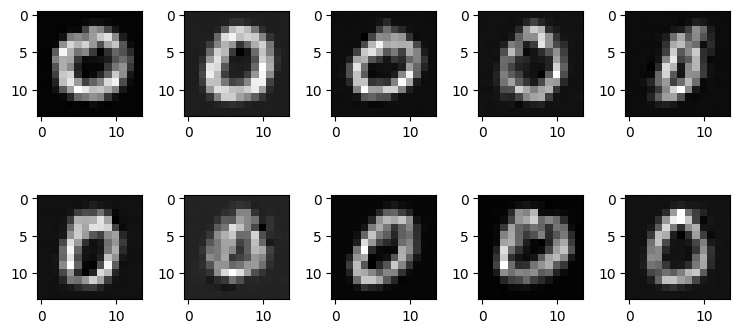

Epoch 781: Train Loss:462.42966672207444 Val BPD: 237756317696.0


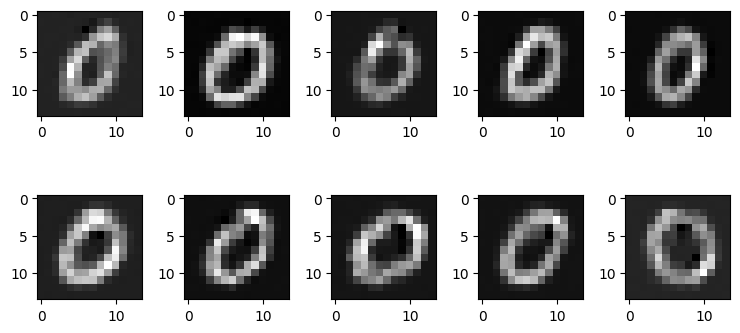

Epoch 791: Train Loss:461.9061013079704 Val BPD: 86714687488.0


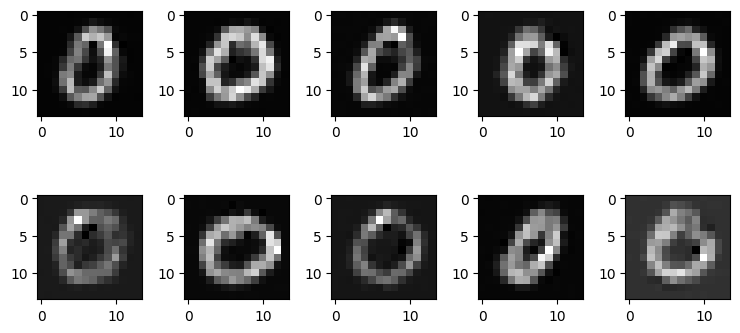

Epoch 801: Train Loss:461.3064068733378 Val BPD: 245129068544.0


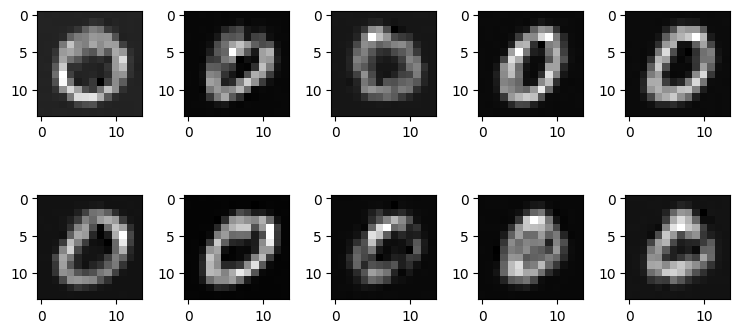

Epoch 811: Train Loss:460.60479281811 Val BPD: 67272855552.0


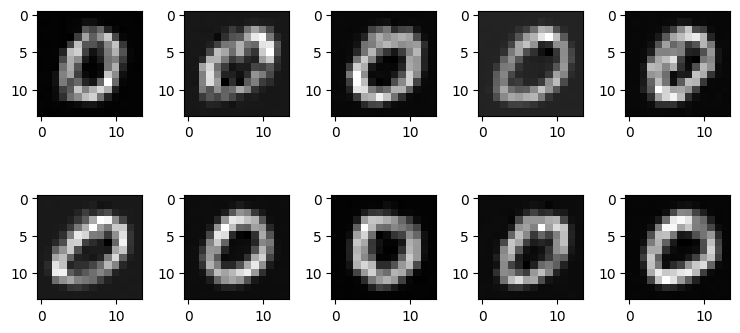

Epoch 821: Train Loss:460.38873485808676 Val BPD: 61531967488.0


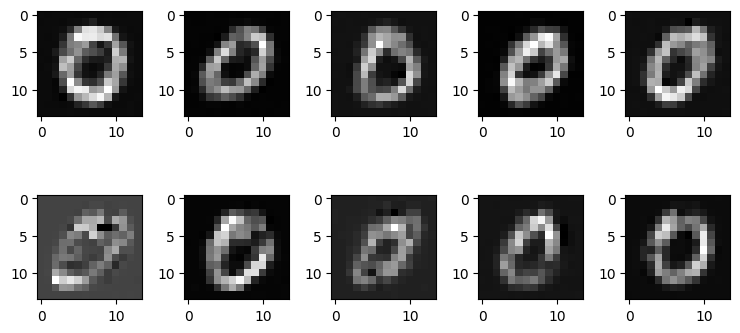

Epoch 831: Train Loss:459.4135988925366 Val BPD: 67705339904.0


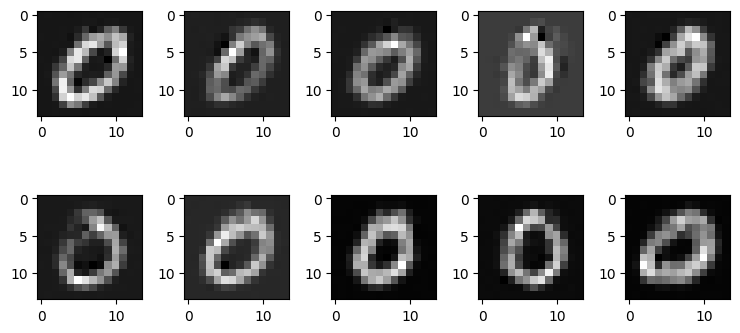

Epoch 841: Train Loss:459.18555856258314 Val BPD: 57899565056.0


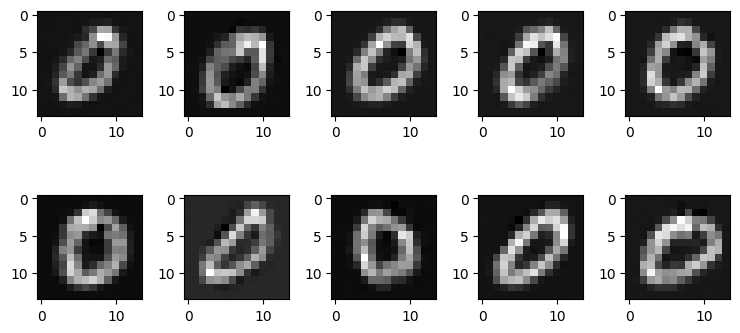

Epoch 851: Train Loss:458.4250397377826 Val BPD: 23370758144.0


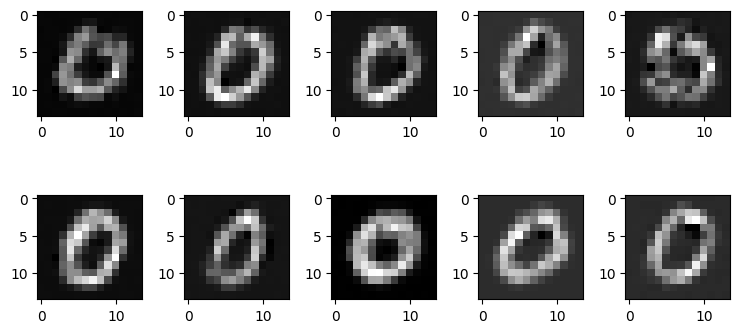

Epoch 861: Train Loss:457.8232662119764 Val BPD: 89222438912.0


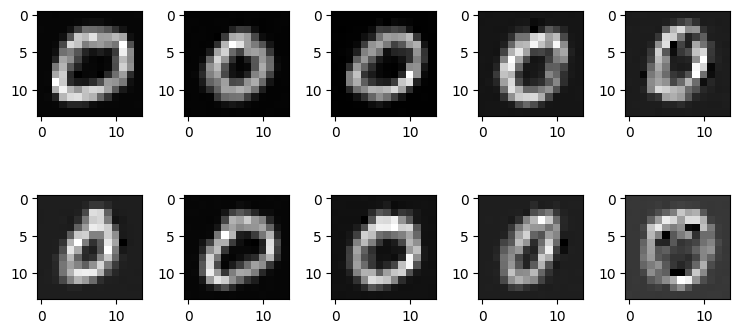

Epoch 871: Train Loss:457.32078909366686 Val BPD: 48479637504.0


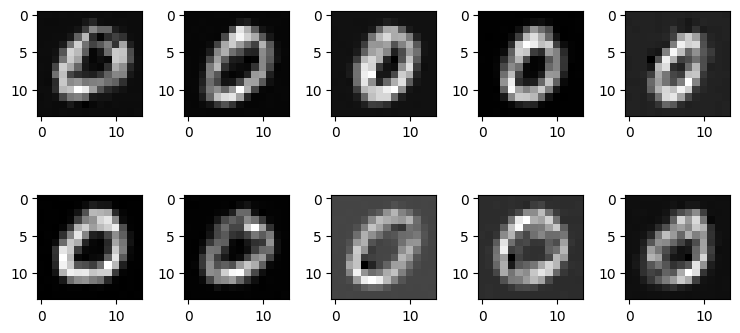

Epoch 881: Train Loss:456.568689873878 Val BPD: 91267866624.0


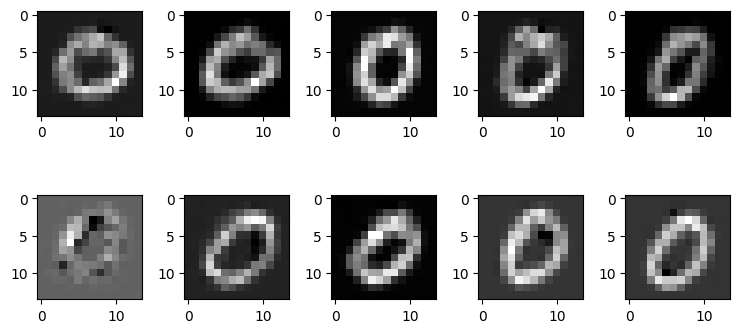

Epoch 891: Train Loss:456.34800168301194 Val BPD: 156982493184.0


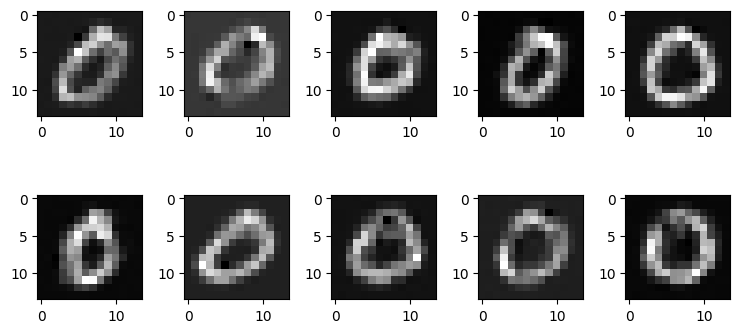

Epoch 901: Train Loss:455.65723630215257 Val BPD: 138352017408.0


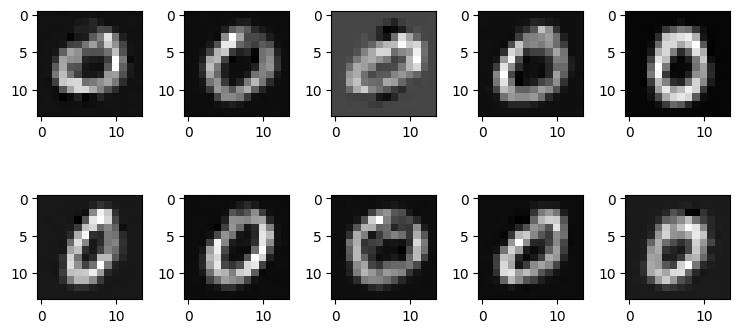

Epoch 911: Train Loss:454.9362046262051 Val BPD: 504056348672.0


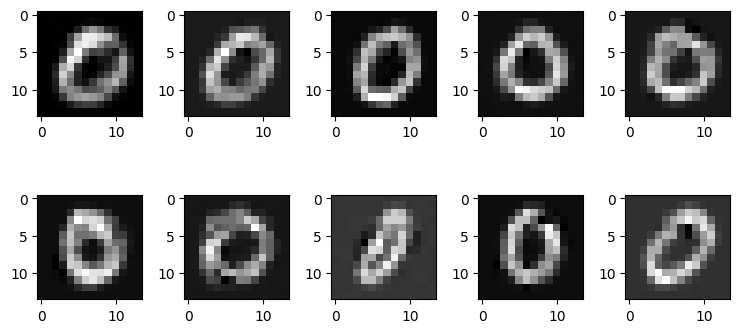

Epoch 921: Train Loss:454.8887368060173 Val BPD: 57285398528.0


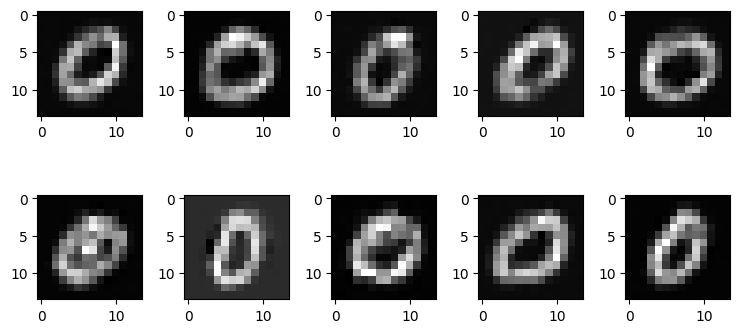

Epoch 931: Train Loss:454.2803046043883 Val BPD: 27272581120.0


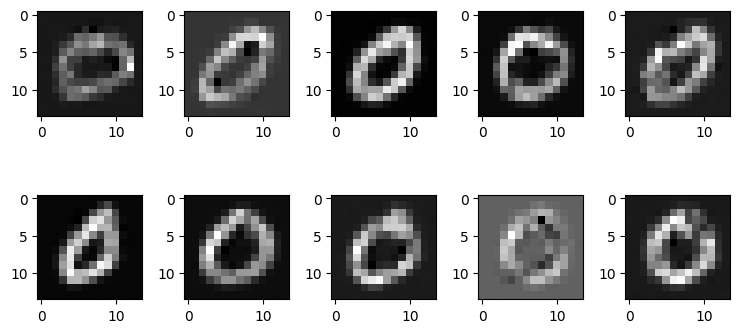

Epoch 941: Train Loss:453.67493844539564 Val BPD: 41470468096.0


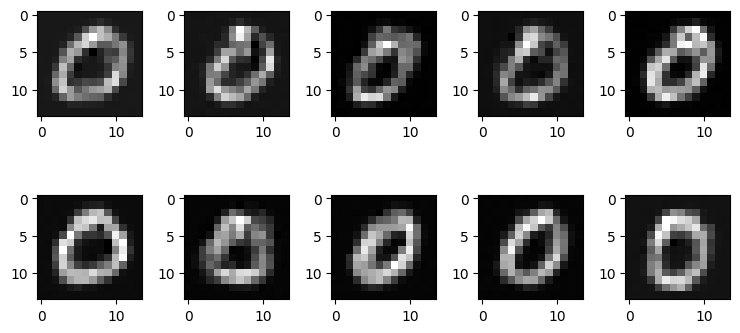

Epoch 951: Train Loss:453.4403608606217 Val BPD: 463928885248.0


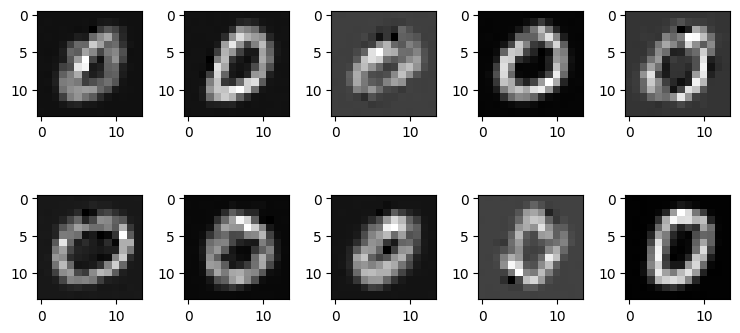

Epoch 961: Train Loss:452.87608759453957 Val BPD: 13122706432.0


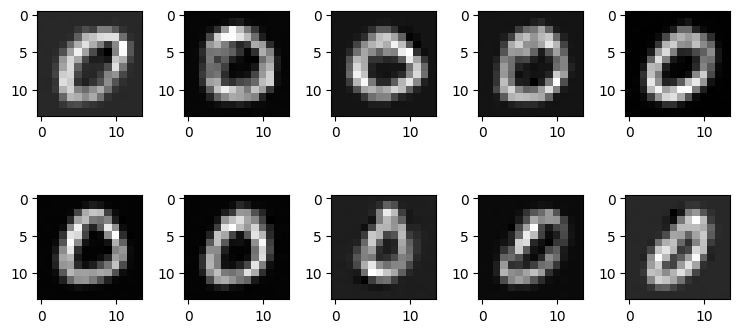

Epoch 971: Train Loss:452.23836176446144 Val BPD: 252950216704.0


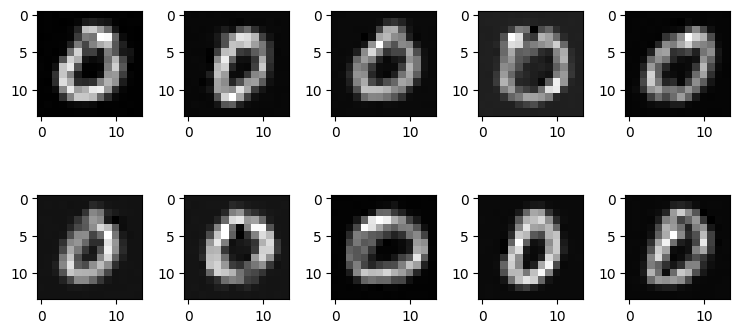

Epoch 981: Train Loss:452.06427716194315 Val BPD: 59674529792.0


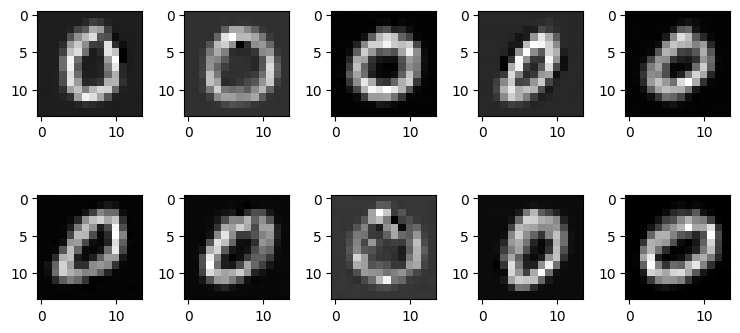

Epoch 991: Train Loss:451.39530587703626 Val BPD: 69988745216.0


In [ ]:
device = 'cpu'
flow = RealNVP(14*14, num_steps=21).to(device)
optim = torch.optim.AdamW(flow.parameters(), lr=1e-5)
epochs = 1000
bits = 8

for module in flow.modules():
    if isinstance(module, (nn.Linear, nn.BatchNorm1d, nn.ReLU)):
        module.to(device)

for ep in range(epochs):
    total_loss = 0.
    iters = 0
    for x, _ in train_loader:
        x = (x * 255).long()
        u = torch.rand_like(x.float())
        x = x + u
        x = x / (2 ** bits)
        x = x.flatten(start_dim=1)

        optim.zero_grad()
        log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (14 * 14)
        loss = - (log_px).mean()
        loss.backward()
        optim.step()
        iters += 1
        total_loss += loss.item()
    if ep % 10 == 0:
        with torch.no_grad():
            val_iters = 0
            total_bpd = 0.
            for x, _ in test_loader:
                x = (x * 255).long()
                u = torch.rand_like(x.float())
                x = x + u
                x = x / (2 ** bits)
                x = x.flatten(start_dim=1)
                log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (14 * 14)
                bpd = -(log_px).mean().cpu() / (np.log(2) * (14 * 14))
                total_bpd += bpd
                val_iters += 1
        samples = flow.sample(10).detach().cpu()
        samples = torch.unflatten(samples, dim=1, sizes=(14, 14)).unsqueeze(1)

        plot_mnist(samples[:, 0], 2, 5)

        print(f"Epoch {ep+1}: Train Loss:{total_loss / iters} Val BPD: {total_bpd / val_iters}")

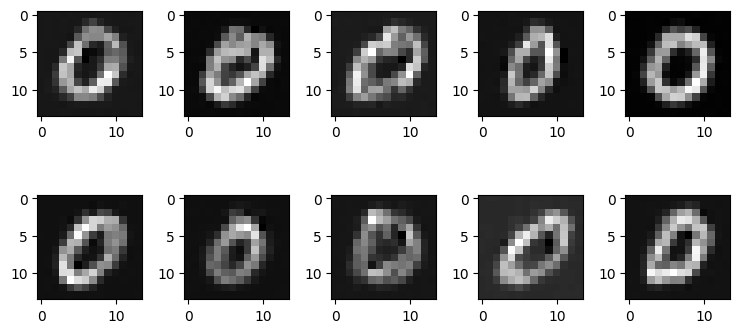

In [ ]:
samples = flow.sample(10).detach().cpu()
samples = torch.unflatten(samples, dim=1, sizes=(14, 14)).unsqueeze(1)
plot_mnist(samples[:,0], 2, 5)

## Bonus zadatak

Predložite implementaciju konvolucijskog normalizirajućeg toka.